Sun May  4 22:03:29 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  NVIDIA A100-SXM4-40GB          Off |   00000000:00:04.0 Off |                    0 |
| N/A   32C    P0             44W /  400W |       0MiB /  40960MiB |      0%      Default |
|                                         |                        |             Disabled |
+-----------------------------------------+-----

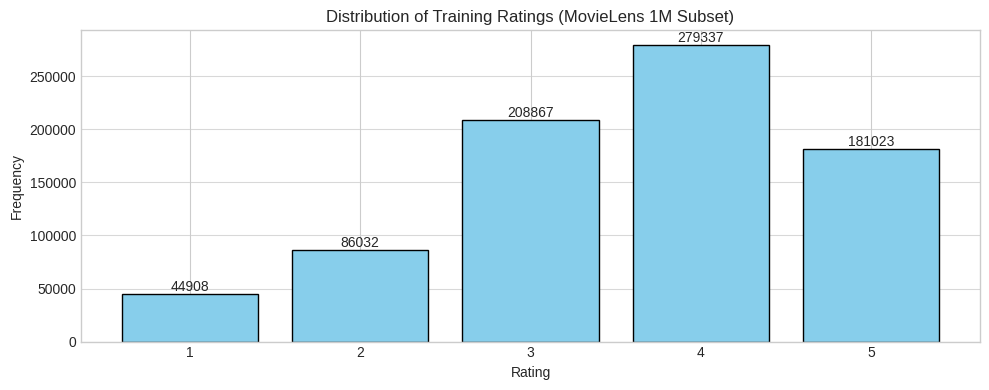

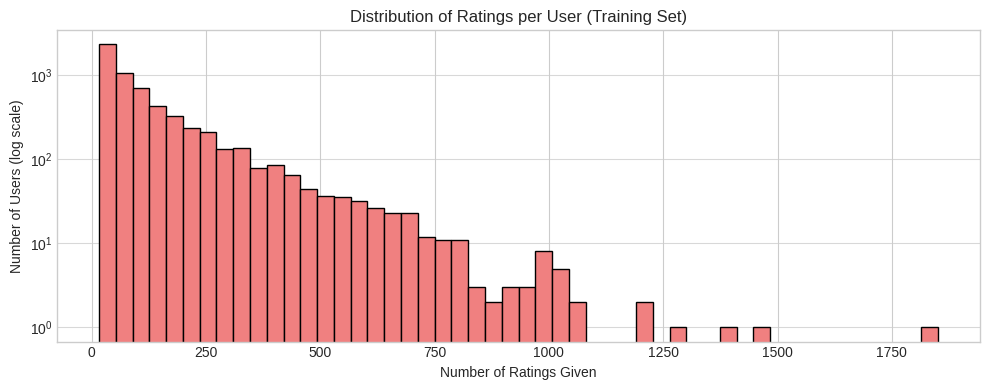

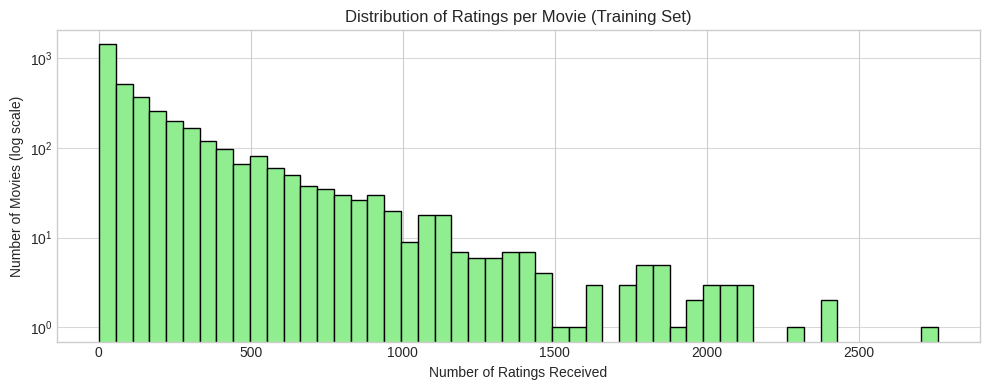

  EucGD Iter 01 | Loss: 4.991e+05 | GradNorm: 3.091e+01 | RMSE: 1.1177 | Time: 0.53s
  EucGD Iter 06 | Loss: 4.990e+05 | GradNorm: 3.090e+01 | RMSE: 1.1176 | Time: 0.52s
  EucGD Iter 11 | Loss: 4.989e+05 | GradNorm: 3.090e+01 | RMSE: 1.1175 | Time: 0.52s
  EucGD Iter 16 | Loss: 4.988e+05 | GradNorm: 3.090e+01 | RMSE: 1.1173 | Time: 0.52s
  EucGD Iter 20 | Loss: 4.988e+05 | GradNorm: 3.090e+01 | RMSE: 1.1173 | Time: 0.52s


In [ ]:
!pip install mpi4py
!pip install POT
!nvidia-smi
!pip install -q --upgrade cupy-cuda12x
!pip install softimpute         # notice: no underscore
# ============================================================================ #
# CELL 1: Project Setup, Imports, Logging, Config
# ============================================================================ #
import os
import sys
import time
import math
import re
import gc
import logging
from pathlib import Path
from typing import Tuple, List, Dict, Optional, Union, Callable, Any
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy import sparse
from scipy.sparse.linalg import svds, LinearOperator # Import LinearOperator
from scipy.optimize import OptimizeResult # For line search return consistency
from numpy.random import default_rng, Generator
from sklearn.model_selection import train_test_split # For train/validation split
# --- Mount Google Drive ---
from google.colab import drive # Uncomment if using Colab
drive.mount("/content/drive", force_remount=True)
DRIVE_MOUNTED = True
# right after the imports
import logging
logging.disable(logging.WARNING)   # hides all warnings emitted via logging

# === ADDED Block 5 (MPI) ===
try:
    from mpi4py import MPI
    COMM = MPI.COMM_WORLD
    RANK_MPI = COMM.Get_rank()
    SIZE_MPI = COMM.Get_size()
    if RANK_MPI == 0: print(f"+++ MPI Detected: Running with {SIZE_MPI} processes. +++")
except ImportError:
    COMM = None
    RANK_MPI = 0
    SIZE_MPI = 1
    # print("+++ MPI Not Found: Running in serial mode. +++") # Less verbose

# === ADDED Block 6 === (Import for OT demo)
try:
    import ot
    OT_AVAILABLE = True
except ImportError:
    OT_AVAILABLE = False
    if RANK_MPI == 0: print("Warning: POT library not found. Skipping Barycentre demo.")

# === ADDED Block 6 (PCA) ===
try:
    from sklearn.decomposition import PCA
    PCA_AVAILABLE = True
except ImportError:
    PCA_AVAILABLE = False
    if RANK_MPI == 0: print("Warning: sklearn not found. Skipping PCA trajectory plot.")


# --- Logging Setup (Initialize Logger FIRST) ---
logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s [%(levelname)s] %(message)s",
    handlers=[logging.StreamHandler(sys.stdout)],
    force=True, # Overwrite any existing config
)
logger = logging.getLogger(__name__)

# --- Mount Drive ---
if RANK_MPI == 0: print("+++ Mounting Google Drive +++")
try:
    # Only rank 0 should try to force remount if needed
    drive.mount('/content/drive', force_remount=(RANK_MPI == 0))
    if RANK_MPI == 0: print("Drive mounted.")
    if COMM and SIZE_MPI > 1: COMM.Barrier() # Ensure drive is mounted
except Exception as e:
    if RANK_MPI == 0: print(f"Error mounting drive: {e}")
    if COMM and SIZE_MPI > 1: COMM.Abort()
    raise

# --- Optional: Try importing CuPy for GPU acceleration ---
# NOTE: Efficient SoftImpute implementation below uses SciPy sparse ops,
# GPU acceleration would require re-implementing the LinearOperator with CuPy sparse.
try:
    import cupy as cp
    import cupyx.scipy.sparse as cpx
    CUPY_AVAILABLE = False # Disable GPU for SoftImpute for now due to LinearOperator complexity
    logger.warning("CuPy found, but GPU acceleration for efficient SoftImpute is NOT enabled in this version.")
    if 'cp' not in locals(): cp = np
    if 'cpx' not in locals(): cpx = sparse
except ImportError:
    CUPY_AVAILABLE = False
    cp = np ; cpx = sparse
    logger.warning("CuPy not found, will run on CPU using NumPy/SciPy.")

logger.info("+++ Cell 1: Setup, Imports, Logging, Config +++")

# --- Global Config ---
# --- MOVIELENS 1M Configuration ---
DATA_DIR_STR = "/content/drive/MyDrive/ml-1m" # ADJUST PATH AS NEEDED
RATINGS_FILENAME = "ratings.dat"
VALIDATION_FRACTION = 0.2 # Hold out 20% for validation
# --- USE COMPLETE DATASET (FIX 1) ---
RATING_LIMIT = None # Load all ratings from ml-1m
RANK = 10 # Factorization rank (r in paper) for non-convex
LAM = 1e-2 # Regularization parameter λ
LAM_SQ = LAM ** 2 # λ^2 for non-convex model factor regularization
LAM_BIAS = 1e-4 # Regularization for bias terms
SEED = 0 # Use consistent seed from long.txt
# --- INCREASED ITERATIONS ---
N_ITERS_ALL = 20 # Iterations/epochs for ALL solvers
CONVEX_RANK_K = 50 # Max rank for Soft-Impute intermediate SVDs
SOFT_IMPUTE_TOL = 1e-4 # Convergence tolerance for Soft-Impute
N_ITERS_CONVEX = N_ITERS_ALL # Use same number of iterations for SoftImpute
# --- SVRG Params ---
INIT_LR_SVRG = 1e-3 # Base Learning rate for SVRG inner solver
SVRG_INNER_STEPS_DIVISOR = 1 # Use full inner pass
GRAD_CLIP_THRESHOLD = 10.0 # Max norm for SVRG gradients before update
RSVRG_BATCH_SIZE = 100 # Batch size for non-convex SVRG refresh step
# --- ALS Params ---
ALS_TOL = 1e-4 # Convergence tolerance for ALS based on RMSE change
ALS_MAX_ITER = N_ITERS_ALL # Use same iter count as others for comparison
# --- RGD/Accelerated Params ---
INIT_LR_RIEMANN = 0.5 # Initial LR for RGD/RAGD/Catalyst/DANE line search
LS_BETA = 0.5         # Line search reduction factor
LS_SIGMA = 1e-4       # Sufficient decrease parameter
RAGD_GAMMA = 1.0; RAGD_MU = 5.0; RAGD_BETA = 5.0
DANE_KAPPA = 1.0
KAPPA_0 = 1e-1; KAPPA_CVX = 1e-1; INNER_T = 5; INNER_S_BASE = 10; MAX_KAPPA_DOUBLINGS = 10
# --- Smaller Initialization Scale ---
INIT_SCALE_NON_CONVEX = 0.01 # Smaller scale for initial U, W
# --- Configuration from Proposal/long.txt ---
RETRACTION_NAME = "orthonormal"  # Options: "orthonormal", "cayley", "projection"
REG_DISTANCE = "euclid"      # Options: "euclid", "retraction"
INNER_SOLVER = "svrg"        # Options: "svrg", "sarah", "spider" (for Catalyst)
ETA_GRAD = 1e-3              # Adaptive stopping tolerance for inner grad norm
ETA_DIST = 1e-4              # Adaptive stopping tolerance for inner step size
CATALYST_INNER_T_EPOCHS = 1 # Epochs for Alg phi_1 check budget
CATALYST_INNER_S_EPOCHS_BASE = 2 # Base epochs for S_k schedule
RSVRG_LR = 1e-3              # Step size for RSVRG/SARAH/SPIDER inner loops

# --- Derived Globals ---
GLOBAL_RNG = default_rng(SEED)
DATA_DIR = Path(DATA_DIR_STR)
I_r = np.eye(RANK, dtype=np.float64) # Identity matrix of size RANK

# Check Data Directory
if DRIVE_MOUNTED and not DATA_DIR.is_dir():
    if RANK_MPI == 0: logger.warning(f"DATA_DIR '{DATA_DIR}' not found. Please check the path.")
elif not DRIVE_MOUNTED:
     if RANK_MPI == 0: logger.warning(f"Google Drive not mounted.")

logger.info("Cell 1 initialisation complete.")

# ============================================================================ #
# CELL 2: Data Loading and Preprocessing (MovieLens 1M)
# ============================================================================ #
logger.info("+++ Cell 2: Loading and Processing Data (MovieLens 1M) +++")
# --- Manifold Operations ---
# --- universal 2-tuple helper for loss/grad (used by Catalyst) ---
def stochastic_gradient_batch(U, user_ids, N_users, N_movies, loss_args):
    """
    Vectorised version of `stochastic_gradient_single_user`.
    Accumulates the (un-scaled) gradient over the provided user_ids.
    """
    G = np.zeros_like(U, dtype=np.float32)
    for uid in user_ids:
        G += stochastic_gradient_single_user(U, int(uid), N_users, N_movies, loss_args)
    return G / max(1, len(user_ids))          # average over the batch

def loss_and_grad_corrected(U, W, bu, bi, *rest):
    """ Wrapper for loss_and_grad_serial_with_biases to return only loss and grad_U. """
    # Calls the main loss function which handles MPI reduction
    loss, gU, *_ = loss_and_grad_serial_with_biases(U, W, bu, bi, *rest)
    return loss, gU # 2-tuple exactly as Catalyst expects
def OrthRetraction(U: np.ndarray, V: np.ndarray) -> np.ndarray:
    """
    QR-based retraction to the Stiefel / Grassmann manifold.
    Uses *reduced* QR so it works on NumPy ≥1.26 and CuPy.
    """
    # Handle potential zero V vector to avoid QR issues
    if np.linalg.norm(V) < 1e-12:
        return U.astype(np.float32)

    # --- FIX: Check for non-finite input ---
    UV = U + V
    if not np.isfinite(UV).all():
        logger.warning("OrthRetraction: Input U+V contains non-finite values. Returning original U.")
        return U.astype(np.float32)
    # --------------------------------------

    try:
        # --- FIX: Use mode='reduced' ---
        Q, R_qr = np.linalg.qr(UV, mode='reduced')
        # ------------------------------

        # Ensure Q has the same shape as U
        if Q.shape[1] < U.shape[1]:
             pad_width = U.shape[1] - Q.shape[1]
             Q = np.pad(Q, ((0, 0), (0, pad_width)), mode='constant')
             logger.warning(f"OrthRetraction: Padded Q due to rank collapse (V norm: {np.linalg.norm(V):.2e})")
        # Optional: Fix sign ambiguity by matching diagonal of R_qr to be positive
        # sign_diag = np.sign(np.diag(R_qr))
        # sign_diag[sign_diag == 0] = 1 # Avoid multiplying by zero
        # Q = Q @ np.diag(sign_diag)
        return Q.astype(np.float32)
    except np.linalg.LinAlgError:
        logger.warning(f"OrthRetraction: QR decomposition failed (V norm: {np.linalg.norm(V):.2e}). Returning original U.")
        return U.astype(np.float32)
    except ValueError as e: # Catch potential value errors from qr
        logger.error(f"OrthRetraction: ValueError during QR: {e}. Returning original U.")
        return U.astype(np.float32)
    except Exception as e: # Catch any other unexpected errors
        logger.error(f"OrthRetraction failed with unexpected error: {e}")
        return U.astype(np.float32)
# Initialize default values
N_users_active, M_movies_active = 0, 0
R_train_coo = sparse.coo_matrix((0, 0), dtype=np.float64)
R_train_coo_orig = sparse.coo_matrix((0, 0), dtype=np.float64) # For original ratings
R_train_csr_orig = sparse.csr_matrix((0,0), dtype=np.float64) # For SoftImpute _matvec
R_train_csc_orig = sparse.csc_matrix((0,0), dtype=np.float64) # For SoftImpute _rmatvec
ratings_train_orig = np.array([], dtype=np.float64) # Keep original ratings for viz
ratings_train_centered = np.array([], dtype=np.float64)
mapped_user_ids_train, mapped_movie_ids_train = np.array([], dtype=np.int32), np.array([], dtype=np.int32)
user_ids_val_final, movie_ids_val_final, ratings_val_true = (np.array([], dtype=np.int32), np.array([], dtype=np.int32), np.array([], dtype=np.float64))
global_mean_rating = 0.0
user_map_global_to_local = {}
movie_map_global_to_local = {}
unique_users_train = np.array([], dtype=np.int32)
unique_movies_train = np.array([], dtype=np.int32)
DATA_AVAILABLE = False
user_data_arrays = {} # Precompute user data for ALS/SVRG
sampling_prob = None # Initialize sampling probability
RSVRG_EPOCH_LEN = 1 # Default epoch length

ratings_file_path = DATA_DIR / RATINGS_FILENAME

if DRIVE_MOUNTED and ratings_file_path.is_file():
    logger.info(f"Loading MovieLens 1M data from: {ratings_file_path}")
    try:
        ratings_df = pd.read_csv(
            ratings_file_path, sep='::', header=None,
            names=['user_id', 'movie_id', 'rating', 'timestamp'],
            engine='python', encoding='latin-1'
        )
        logger.info(f"Loaded {len(ratings_df)} ratings.")
        DATA_AVAILABLE = True

        if RATING_LIMIT is not None and RATING_LIMIT > 0 and len(ratings_df) > RATING_LIMIT:
             logger.info(f"Subsampling ratings from {len(ratings_df)} to {RATING_LIMIT}")
             ratings_df = ratings_df.sample(n=RATING_LIMIT, random_state=SEED)

        stratify_arg = ratings_df['user_id'] if RATING_LIMIT is None else None
        if stratify_arg is None and RATING_LIMIT is not None:
            logger.warning("Stratify is disabled due to RATING_LIMIT being set.")
        train_df, val_df = train_test_split(
            ratings_df, test_size=VALIDATION_FRACTION, random_state=SEED, stratify=stratify_arg)
        logger.info(f"Train size: {len(train_df)}, Validation size: {len(val_df)}")

        user_ids_train_orig = train_df['user_id'].values; movie_ids_train_orig = train_df['movie_id'].values
        ratings_train_orig = train_df['rating'].values.astype(np.float64)
        user_ids_val_orig = val_df['user_id'].values; movie_ids_val_orig = val_df['movie_id'].values
        ratings_val_true = val_df['rating'].values.astype(np.float64) # Keep original for validation

        global_mean_rating = ratings_train_orig.mean()
        logger.info(f"Global mean rating (training): {global_mean_rating:.4f}")

        unique_users_train, mapped_user_ids_train = np.unique(user_ids_train_orig, return_inverse=True)
        unique_movies_train, mapped_movie_ids_train = np.unique(movie_ids_train_orig, return_inverse=True)
        N_users_active = len(unique_users_train); M_movies_active = len(unique_movies_train)
        user_map_global_to_local = {orig_id: local_id for local_id, orig_id in enumerate(unique_users_train)}
        movie_map_global_to_local = {orig_id: local_id for local_id, orig_id in enumerate(unique_movies_train)}
        logger.info(f"Active users in training: {N_users_active}, Active movies in training: {M_movies_active}")

        ratings_train_centered = ratings_train_orig - global_mean_rating

        val_user_mask = np.isin(user_ids_val_orig, unique_users_train)
        val_movie_mask = np.isin(movie_ids_val_orig, unique_movies_train)
        val_valid_mask = val_user_mask & val_movie_mask
        user_ids_val_filt = user_ids_val_orig[val_valid_mask]; movie_ids_val_filt = movie_ids_val_orig[val_valid_mask]
        ratings_val_true = ratings_val_true[val_valid_mask] # Filter true ratings accordingly
        user_ids_val_final = np.array([user_map_global_to_local.get(uid, -1) for uid in user_ids_val_filt], dtype=np.int32)
        movie_ids_val_final = np.array([movie_map_global_to_local.get(mid, -1) for mid in movie_ids_val_filt], dtype=np.int32)
        valid_map_mask = (user_ids_val_final != -1) & (movie_ids_val_final != -1) # Filter out any potential misses
        user_ids_val_final = user_ids_val_final[valid_map_mask]; movie_ids_val_final = movie_ids_val_final[valid_map_mask]
        ratings_val_true = ratings_val_true[valid_map_mask] # Filter again after mapping
        logger.info(f"Validation pairs mapped to training users/movies: {len(user_ids_val_final)}")

        if ratings_train_centered.size > 0:
            R_train_coo = sparse.coo_matrix((ratings_train_centered, (mapped_movie_ids_train, mapped_user_ids_train)), shape=(M_movies_active, N_users_active), dtype=np.float64)
            R_train_coo.eliminate_zeros()
            logger.info(f"Built sparse training matrix (Centered) R_train_coo: shape={R_train_coo.shape}, nnz={R_train_coo.nnz}")
            R_train_coo_orig = sparse.coo_matrix((ratings_train_orig, (mapped_movie_ids_train, mapped_user_ids_train)), shape=(M_movies_active, N_users_active), dtype=np.float64)
            R_train_coo_orig.eliminate_zeros()
            R_train_csr_orig = R_train_coo_orig.tocsr(); R_train_csc_orig = R_train_coo_orig.tocsc()
            logger.info(f"Built sparse training matrix (Original) R_train_coo_orig: shape={R_train_coo_orig.shape}, nnz={R_train_coo_orig.nnz}")

            # Precompute user data structures for ALS/SVRG
            logger.info("Precomputing user data structures...")
            t_precomp_start = time.time()
            user_data_arrays = {}
            for r, c, v in zip(R_train_coo_orig.row, R_train_coo_orig.col, R_train_coo_orig.data):
                user_data_arrays.setdefault(c, []).append((r, v))
            for u, rating_list in user_data_arrays.items():
                if rating_list:
                    movie_indices_list, rs_list = zip(*rating_list)
                    user_data_arrays[u] = {'movies': np.array(list(movie_indices_list),dtype=np.int32),
                                           'rs': np.array(list(rs_list),dtype=np.float64)} # Store original ratings
            logger.info(f"User data precomputation done in {time.time() - t_precomp_start:.2f}s")
            # Calculate importance sampling weights (consistent across ranks)
            all_user_indices_global = np.array(list(user_data_arrays.keys()), dtype=np.int32)
            num_active_users_global = len(all_user_indices_global)
            user_weights = None; use_importance_sampling = False
            if num_active_users_global > 0:
                if RANK_MPI == 0: print("Calculating importance sampling weights...")
                user_ratings_count = [len(user_data_arrays[u_idx]['movies']) if u_idx in user_data_arrays and 'movies' in user_data_arrays[u_idx] else 0 for u_idx in all_user_indices_global]
                user_weights_np = np.array(user_ratings_count, dtype=np.float64)
                sum_weights = user_weights_np.sum()
                if sum_weights > 1e-9:
                    user_weights_np /= sum_weights
                    user_weights = user_weights_np # Probabilities aligned with all_user_indices_global
                    use_importance_sampling = True
                    if RANK_MPI == 0: print(f"Importance sampling enabled (weights based on {sum_weights:.0f} ratings).")
                else:
                     if RANK_MPI == 0: print("Warning: Cannot compute importance sampling weights. Using uniform.")
            else:
                 if RANK_MPI == 0: print("No active users, cannot use importance sampling.")
            sampling_prob = user_weights if use_importance_sampling else None
            RSVRG_EPOCH_LEN = math.ceil(num_active_users_global / RSVRG_BATCH_SIZE) if num_active_users_global > 0 else 1
            if RANK_MPI == 0: print(f"RSVRG Epoch Length set to {RSVRG_EPOCH_LEN} batches.")

        else: logger.error("No training ratings available.")

    except FileNotFoundError: logger.error(f"MovieLens file not found: {ratings_file_path}"); DATA_AVAILABLE = False
    except Exception as e: logger.error(f"Error processing MovieLens: {e}", exc_info=True); DATA_AVAILABLE = False
elif not DRIVE_MOUNTED: logger.error("Google Drive not mounted.")
else: logger.error(f"Data directory {DATA_DIR} or ratings file {RATINGS_FILENAME} not found.")

gc.collect()
logger.info("Cell 2: Data Loading and Preprocessing Complete.")
logger.info(f"Active Dimensions: M_movies={M_movies_active}, N_users={N_users_active}")
logger.info(f"Training Ratings: {R_train_coo.nnz}")
logger.info(f"Validation Ratings (for RMSE): {ratings_val_true.size}")


# ============================================================================ #
# CELL 2.5: Data Visualization
# ============================================================================ #
logger.info("+++ Cell 2.5: Visualizing Loaded Data +++")

if RANK_MPI == 0: # Only rank 0 should plot
    if DATA_AVAILABLE and ratings_train_orig.size > 0:
        plt.style.use('seaborn-v0_8-whitegrid') # Use a nice style

        # 1. Rating Distribution
        plt.figure(figsize=(10, 4))
        counts, bins, patches = plt.hist(ratings_train_orig, bins=[0.5, 1.5, 2.5, 3.5, 4.5, 5.5], rwidth=0.8, align='mid', color='skyblue', edgecolor='black')
        bin_centers = 0.5 * (bins[:-1] + bins[1:])
        for count, x in zip(counts, bin_centers):
            if count > 0: plt.text(x, count, str(int(count)), ha='center', va='bottom')
        plt.title('Distribution of Training Ratings (MovieLens 1M Subset)')
        plt.xlabel('Rating'); plt.ylabel('Frequency')
        plt.xticks([1, 2, 3, 4, 5]); plt.grid(axis='y', alpha=0.75)
        plt.tight_layout(); plt.show()

        # 2. Ratings per User
        user_rating_counts = np.bincount(mapped_user_ids_train)
        plt.figure(figsize=(10, 4))
        plt.hist(user_rating_counts[user_rating_counts > 0], bins=50, log=True, color='lightcoral', edgecolor='black')
        plt.title('Distribution of Ratings per User (Training Set)')
        plt.xlabel('Number of Ratings Given'); plt.ylabel('Number of Users (log scale)')
        plt.grid(axis='y', alpha=0.75); plt.tight_layout(); plt.show()

        # 3. Ratings per Movie
        movie_rating_counts = np.bincount(mapped_movie_ids_train)
        plt.figure(figsize=(10, 4))
        plt.hist(movie_rating_counts[movie_rating_counts > 0], bins=50, log=True, color='lightgreen', edgecolor='black')
        plt.title('Distribution of Ratings per Movie (Training Set)')
        plt.xlabel('Number of Ratings Received'); plt.ylabel('Number of Movies (log scale)')
        plt.grid(axis='y', alpha=0.75); plt.tight_layout(); plt.show()
        logger.info("Cell 2.5: Data Visualization Complete.")
    else:
        logger.warning("Skipping data visualization as no data was loaded.")

# ============================================================================ #
# CELL 3: Model Helpers (CONSOLIDATED)
# ============================================================================ #
logger.info("+++ Cell 3: Defining ALL Model Helpers +++")

# --- Retraction Factory ---
class RetractionFactory:
    _registry = {}
    @classmethod
    def register(cls, name):
        def decorator(fn): cls._registry[name] = fn; return fn
        return decorator
    @classmethod
    def get(cls, name):
        if name not in cls._registry: raise KeyError(f"Unknown retraction '{name}'. Available: {list(cls._registry.keys())}")
        return cls._registry[name]
# --- Register Retractions ---
@RetractionFactory.register("orthonormal")
def _retract_qr(U: np.ndarray, V: np.ndarray) -> np.ndarray:
    """QR-based retraction."""
    if np.linalg.norm(V) < 1e-12: return U.astype(np.float32)
    UV = U + V
    if not np.isfinite(UV).all(): logger.warning("OrthRetraction: Input U+V non-finite."); return U.astype(np.float32)
    try:
        Q, R_qr = np.linalg.qr(UV, mode='reduced') # Use 'reduced'
        if Q.shape[1] < U.shape[1]:
             pad_width = U.shape[1] - Q.shape[1]; Q = np.pad(Q, ((0, 0), (0, pad_width)), mode='constant')
             logger.warning(f"OrthRetraction: Padded Q")
        return Q.astype(np.float32)
    except Exception as e: logger.error(f"OrthRetraction failed: {e}"); return U.astype(np.float32)
@RetractionFactory.register("cayley")
def _retract_cayley(U: np.ndarray, V: np.ndarray, alpha: float = 0.1) -> np.ndarray:
    """ Simple Cayley approx using QR of ambient step. """
    return _retract_qr(U, alpha * V)
@RetractionFactory.register("projection")
def _retract_projection(U: np.ndarray, V: np.ndarray) -> np.ndarray:
    """ Projection (polar decomposition) retraction. """
    U64 = U.astype(np.float64, copy=False); V64 = V.astype(np.float64, copy=False)
    Z = U64 + V64; G = Z.T @ Z
    try:
        s, P = np.linalg.eigh(G); s_safe = np.maximum(s, 1e-12)
        s_inv_sqrt = 1.0 / np.sqrt(s_safe); G_mhalf = P @ np.diag(s_inv_sqrt) @ P.T
        result = (Z @ G_mhalf).astype(np.float32)
        if result.shape != U.shape: logger.warning(f"Projection Retraction Warning: Shape mismatch. Falling back to QR."); return _retract_qr(U, V)
        return result
    except Exception as e: logger.warning(f"Projection Retraction Warning: {e}. Falling back to QR."); return _retract_qr(U, V)
# --- Get the chosen retraction function ---
R_fn = RetractionFactory.get(RETRACTION_NAME)
if RANK_MPI == 0: logger.info(f"Using Retraction: {RETRACTION_NAME}")

# --- Other Manifold Helpers ---
def ProjTangent(U: np.ndarray, G: np.ndarray) -> np.ndarray:
    """Project G onto tangent space at U (Grassmann)."""
    return (G - U @ (U.T @ G)).astype(np.float32)
def LogMapApprox(U_base: np.ndarray, U_target: np.ndarray) -> np.ndarray:
    """Approximate inverse retraction (log map)."""
    return ProjTangent(U_base, U_target - U_base)
def RegularizeGradChordalApprox(U: np.ndarray, U_old: np.ndarray, kappa: float) -> np.ndarray:
    """Approximate gradient of distance regularization term."""
    U = U.astype(np.float32); U_old = U_old.astype(np.float32);
    if REG_DISTANCE == "euclid": S = U.T @ U_old; grad_ambient = U @ (S - S.T); return kappa * ProjTangent(U, grad_ambient)
    elif REG_DISTANCE == "retraction": v = LogMapApprox(U, U_old); return -kappa * v
    else: raise ValueError(f"Unknown REG_DISTANCE type: {REG_DISTANCE}")

# --- RMSE Evaluation ---
def evaluate_rmse_with_biases(
    U: np.ndarray, W: np.ndarray,
    user_bias: np.ndarray, movie_bias: np.ndarray, global_mean: float,
    probe_users_mapped: np.ndarray, probe_movies_mapped: np.ndarray, probe_ratings_true: np.ndarray # Now contains true ratings
) -> float:
    """Computes RMSE on the validation set including bias terms and clamping."""
    if probe_ratings_true.size == 0: return np.nan # Check if validation set is empty
    U = U.astype(np.float64, copy=False); W = W.astype(np.float64, copy=False)
    user_bias = user_bias.astype(np.float64, copy=False); movie_bias = movie_bias.astype(np.float64, copy=False)
    local_sum_sq_err = 0.0; local_count = 0
    try:
        if M_movies_active == 0 or N_users_active == 0: return np.nan
        if probe_movies_mapped.size > 0 and (probe_movies_mapped.max() >= M_movies_active or probe_movies_mapped.min() < 0): return np.nan
        if probe_users_mapped.size > 0 and (probe_users_mapped.max() >= N_users_active or probe_users_mapped.min() < 0): return np.nan
        dot_prods = np.array([np.dot(U[m, :], W[:, u]) for m, u in zip(probe_movies_mapped, probe_users_mapped)], dtype=np.float64)
        preds_raw = global_mean + user_bias[probe_users_mapped] + movie_bias[probe_movies_mapped] + dot_prods
        preds_clamped = np.clip(preds_raw, 1.0, 5.0)
        if not np.isfinite(preds_clamped).all(): preds_clamped = np.nan_to_num(preds_clamped, nan=global_mean)
        if not np.isfinite(probe_ratings_true).all(): probe_ratings_true = np.nan_to_num(probe_ratings_true)
        squared_errors = (preds_clamped - probe_ratings_true)**2
        local_sum_sq_err = np.sum(squared_errors)
        local_count = len(squared_errors)
    except IndexError as e: logger.error(f"IndexError during biased RMSE: {e}"); return np.nan
    except Exception as e: logger.error(f"Error during biased RMSE: {e}"); return np.nan
    # --- MPI Reduction for RMSE ---
    if COMM and SIZE_MPI > 1:
        global_sum_sq_err_buf = np.array(local_sum_sq_err, dtype=np.float64); global_count_buf = np.array(local_count, dtype=np.int64)
        global_sum_sq_err = np.array(0.0, dtype=np.float64); global_count = np.array(0, dtype=np.int64)
        COMM.Allreduce(global_sum_sq_err_buf, global_sum_sq_err, op=MPI.SUM); COMM.Allreduce(global_count_buf, global_count, op=MPI.SUM)
        if global_count > 0: mean_squared_error = global_sum_sq_err / global_count
        else: return np.nan
    else: # Serial case
        if local_count > 0: mean_squared_error = local_sum_sq_err / local_count
        else: return np.nan
    mean_squared_error = max(0.0, mean_squared_error); rmse = np.sqrt(mean_squared_error)
    return float(rmse) if np.isfinite(rmse) else np.nan

# --- RMSE Helper for SoftImpute (No Biases) ---
def evaluate_rmse_low_rank(U, S, V, probe_movies_mapped, probe_users_mapped, probe_ratings_true, use_gpu=False):
    """Computes RMSE for low-rank model X = USV^T against true ratings."""
    if probe_ratings_true.size == 0: return np.nan
    xp = cp if use_gpu else np
    try:
        if M_movies_active == 0 or N_users_active == 0: return np.nan
        if probe_movies_mapped.size > 0 and (probe_movies_mapped.max() >= M_movies_active or probe_movies_mapped.min() < 0): return np.nan
        if probe_users_mapped.size > 0 and (probe_users_mapped.max() >= N_users_active or probe_users_mapped.min() < 0): return np.nan
        U_dev = xp.asarray(U); S_dev = xp.asarray(S); V_dev = xp.asarray(V)
        probe_movies_dev = xp.asarray(probe_movies_mapped); probe_users_dev = xp.asarray(probe_users_mapped)
        probe_ratings_dev = xp.asarray(probe_ratings_true)
        term2 = S_dev * V_dev[probe_users_dev, :]
        preds_raw = xp.sum(U_dev[probe_movies_dev, :] * term2, axis=1)
        preds_clamped = xp.clip(preds_raw, 1.0, 5.0)
        if not xp.isfinite(preds_clamped).all(): preds_clamped = xp.nan_to_num(preds_clamped, nan=3.0)
        if not xp.isfinite(probe_ratings_dev).all(): probe_ratings_dev = xp.nan_to_num(probe_ratings_dev)
        mse_dev = xp.mean((preds_clamped - probe_ratings_dev)**2)
        mse = float(cp.asnumpy(mse_dev) if use_gpu else mse_dev)
        rmse = np.sqrt(mse) if mse >= 0 else np.nan
    except IndexError as e: logger.error(f"IndexError during low-rank RMSE: {e}"); return np.nan
    except Exception as e: logger.error(f"Error during low-rank RMSE: {e}"); return np.nan
    return float(rmse) if np.isfinite(rmse) else np.nan

# --- Initialization ---
def initialize_factors_and_biases(M: int, N: int, R: int, rng: Generator, scale: float) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """Initializes U, W, user_bias, movie_bias."""
    U = None; W = None; user_bias = None; movie_bias = None
    if RANK_MPI == 0:
        U = rng.standard_normal(size=(M, R)).astype(np.float64) * scale
        W = rng.standard_normal(size=(R, N)).astype(np.float64) * scale
        user_bias = np.zeros(N, dtype=np.float64)
        movie_bias = np.zeros(M, dtype=np.float64)
        if M >= R: U_orth, _ = np.linalg.qr(U, mode='reduced'); U = U_orth.astype(np.float64)
        else: logger.warning(f"M ({M}) < R ({R}). Cannot orthonormalize U.")
    if COMM and SIZE_MPI > 1:
        if RANK_MPI != 0: U = np.empty((M, R), dtype=np.float64); W = np.empty((R, N), dtype=np.float64); user_bias = np.empty(N, dtype=np.float64); movie_bias = np.empty(M, dtype=np.float64)
        COMM.Bcast(U, root=0); COMM.Bcast(W, root=0); COMM.Bcast(user_bias, root=0); COMM.Bcast(movie_bias, root=0)
    return U, W, user_bias, movie_bias

# --- Initial State Recorder ---
def record_initial_state_biased(U, W, user_bias, movie_bias, loss_args_biased, eval_args_biased):
    """Computes and logs initial state for biased models."""
    current_loss, gU0, gW0, gBu0, gBi0 = loss_and_grad_serial_with_biases(U, W, user_bias, movie_bias, *loss_args_biased)
    current_rmse = evaluate_rmse_with_biases(U, W, user_bias, movie_bias, *eval_args_biased)
    gU_proj_0 = ProjTangent(U, gU0)
    grad_norm_U_riemann = np.linalg.norm(gU_proj_0)
    grad_norm_W = np.linalg.norm(gW0); grad_norm_Bu = np.linalg.norm(gBu0); grad_norm_Bi = np.linalg.norm(gBi0)
    if RANK_MPI == 0: logger.info(
        f"Epoch 00 (Init): Loss={current_loss:.4e}, RMSE={current_rmse:.4f}, "
        f"||Proj gU||={grad_norm_U_riemann:.2e}, ||gW||={grad_norm_W:.2e}, "
        f"||gBu||={grad_norm_Bu:.2e}, ||gBi||={grad_norm_Bi:.2e}"
    )
    if not np.isfinite(current_loss): raise ValueError("Initial loss is not finite.")
    return current_loss, current_rmse, gU0, gW0, gBu0, gBi0

# --- Armijo Line Search ---
def ArmijoLineSearchRiemannian(
    U: np.ndarray, G_euclidean: np.ndarray, loss_args: tuple, current_loss: float,
    lr_init: float, beta: float, sigma: float, max_ls_iter: int = 20
) -> Tuple[float, np.ndarray, float]:
    """Performs Armijo line search using retraction."""
    lr = lr_init
    G_proj = ProjTangent(U, G_euclidean)
    G_proj_norm_sq = np.linalg.norm(G_proj)**2
    if G_proj_norm_sq < 1e-14: return 0.0, U, current_loss
    for ls_iter in range(max_ls_iter):
        step_vec = -lr * G_proj
        U_next = R_fn(U, step_vec) # Use chosen retraction
        if not np.isfinite(U_next).all(): lr *= beta; continue
        try:
            W_ls, ub_ls, mb_ls, *rest_args = loss_args
            loss_next, _, _, _, _ = loss_and_grad_serial_with_biases(U_next, W_ls, ub_ls, mb_ls, *rest_args)
        except Exception as e: logger.error(f"Armijo LS Error: {e}"); return 0.0, U, current_loss
        if not np.isfinite(loss_next): lr *= beta; continue
        required_decrease = sigma * lr * G_proj_norm_sq
        actual_decrease = current_loss - loss_next
        if actual_decrease >= required_decrease - 1e-9: return lr, U_next, loss_next
        lr *= beta
        if lr < 1e-14: break
    logger.debug("Armijo LS failed."); return 0.0, U, current_loss

# --- Adaptive Stopping Check ---
def should_stop_subproblem(G_proj, step_vec):
    """Return True if both criteria are already small."""
    grad_norm_proj = np.linalg.norm(G_proj)
    step_norm = np.linalg.norm(step_vec)
    stop = (grad_norm_proj < ETA_GRAD and step_norm < ETA_DIST)
    return stop

# --- Adaptive Kappa Update ---
def update_kappa_adaptive(kappa_prev, h_hist, dist_hist, U_local,
                          gamma=2.0, window=3,
                          kappa_min=1e-4, kappa_max=1e12):
    """ Adaptive kappa update using local curvature estimate. """
    if U_local.shape[1] == 0: return kappa_min # Handle empty matrix case
    v = GLOBAL_RNG.standard_normal(size=(U_local.shape[1], 1)).astype(U_local.dtype)
    v /= np.linalg.norm(v) + 1e-12
    U_local_64 = U_local.astype(np.float64); v_64 = v.astype(np.float64)
    lambda_max_sq = 0.0
    for _ in range(2): # 2 power iterations on U^T U
        Av = U_local_64.T @ (U_local_64 @ v_64)
        lambda_max_sq = v_64.T @ Av
        v_norm = np.linalg.norm(Av); v_64 = Av / (v_norm + 1e-12)
    L_local = np.sqrt(max(0.0, lambda_max_sq.item()))
    target_ratio = 0.9; target = target_ratio * L_local
    kappa_new = np.clip(target, kappa_min, kappa_max)
    return float(kappa_new)

# --- OT Demo Helper ---
def run_barycentre_demo(n_grid=200, reg=1e-1, rng_seed=0):
    """ POT demo: 3 one-dimensional Gaussians -> entropic Wasserstein barycenter """
    if not OT_AVAILABLE: return None
    grid = np.linspace(-8.0, 8.0, n_grid)
    M = ot.dist(grid.reshape(-1, 1), grid.reshape(-1, 1)) ** 2
    means = np.array([-3.0, 0.0, 3.0]); sigmas = np.array([0.5, 1.0, 0.7])
    sources = np.vstack([np.exp(-0.5 * ((grid - m) / s) ** 2) / (s * np.sqrt(2 * np.pi)) for m, s in zip(means, sigmas)]).T
    sources /= sources.sum(axis=0, keepdims=True)
    bary, log = ot.bregman.barycenter(sources, M, reg, weights=None, numItermax=1000, stopThr=1e-7, log=True)
    return {'grid': grid, 'sources': sources, 'barycenter': bary, 'log': log}


logger.info("Cell 3: Model Helpers Defined.")

# ============================================================================ #
# CELL 4: Non-Convex Solvers (SVRG, ALS, Euclidean GD) - Renumbered
# ============================================================================ #
logger.info("+++ Cell 4: Defining Non-Convex Solvers +++")
# --- Loss/Gradient Functions ---
def loss_and_grad_serial_with_biases(
    U: np.ndarray, W: np.ndarray, user_bias: np.ndarray, movie_bias: np.ndarray,
    global_mean: float,
    rows_idx: np.ndarray, cols_idx: np.ndarray, vals_true_centered: np.ndarray, # Centered ratings
    n_movies_func: int, n_users_func: int, rank_func: int,
    lambda_sq_func: float, lambda_bias_func: float
) -> Tuple[float, np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Computes loss and gradients for U, W, user_bias, movie_bias. """
    # ... (implementation from v11) ...
    U = U.astype(np.float64, copy=False); W = W.astype(np.float64, copy=False)
    user_bias = user_bias.astype(np.float64, copy=False); movie_bias = movie_bias.astype(np.float64, copy=False)
    if vals_true_centered.size == 0: return 0.0, np.zeros_like(U), np.zeros_like(W), np.zeros_like(user_bias), np.zeros_like(movie_bias)
    try:
        W_cols = W[:, cols_idx]; U_rows = U[rows_idx, :]
        dot_prods = np.sum(U_rows * W_cols.T, axis=1)
        preds_residual = user_bias[cols_idx] + movie_bias[rows_idx] + dot_prods
    except IndexError as e: logger.error(f"Indexing error in loss_and_grad_serial_with_biases - {e}"); raise
    valid_mask = np.isfinite(preds_residual) & np.isfinite(vals_true_centered)
    if not np.all(valid_mask):
        logger.warning(f"Filtering {np.sum(~valid_mask)} non-finite values in loss_and_grad_serial_with_biases.")
        rows_idx_filt = rows_idx[valid_mask]; cols_idx_filt = cols_idx[valid_mask]
        vals_true_filt = vals_true_centered[valid_mask]; preds_filt = preds_residual[valid_mask]
        if preds_filt.size == 0: return np.inf, np.zeros_like(U), np.zeros_like(W), np.zeros_like(user_bias), np.zeros_like(movie_bias)
    else:
        rows_idx_filt, cols_idx_filt, vals_true_filt, preds_filt = rows_idx, cols_idx, vals_true_centered, preds_residual
    errors = preds_filt - vals_true_filt
    loss_obs = 0.5 * np.sum(errors**2)
    loss_reg_U = 0.5 * lambda_sq_func * np.sum(U**2); loss_reg_W = 0.5 * lambda_sq_func * np.sum(W**2)
    loss_reg_bu = 0.5 * lambda_bias_func * np.sum(user_bias**2); loss_reg_bi = 0.5 * lambda_bias_func * np.sum(movie_bias**2)
    total_loss = loss_obs + loss_reg_U + loss_reg_W + loss_reg_bu + loss_reg_bi
    E_sparse = sparse.csr_matrix((errors, (rows_idx_filt, cols_idx_filt)), shape=(n_movies_func, n_users_func))
    E_sparse_csc = E_sparse.tocsc()
    grad_U = E_sparse @ W.T + lambda_sq_func * U
    grad_W = U.T @ E_sparse_csc + lambda_sq_func * W
    grad_user_bias = np.array(E_sparse.sum(axis=0)).flatten() + lambda_bias_func * user_bias
    grad_movie_bias = np.array(E_sparse.sum(axis=1)).flatten() + lambda_bias_func * movie_bias
    if not np.isfinite(grad_U).all(): grad_U = np.nan_to_num(grad_U)
    if not np.isfinite(grad_W).all(): grad_W = np.nan_to_num(grad_W)
    if not np.isfinite(grad_user_bias).all(): grad_user_bias = np.nan_to_num(grad_user_bias)
    if not np.isfinite(grad_movie_bias).all(): grad_movie_bias = np.nan_to_num(grad_movie_bias)
    if not np.isfinite(total_loss): total_loss = np.inf
    return float(total_loss), grad_U.astype(np.float64), grad_W.astype(np.float64), grad_user_bias.astype(np.float64), grad_movie_bias.astype(np.float64)

def gradient_batch_with_biases(
    U: np.ndarray, W: np.ndarray, user_bias: np.ndarray, movie_bias: np.ndarray,
    indices: np.ndarray, # Indices into GLOBAL triplets
    rows_idx: np.ndarray, cols_idx: np.ndarray, vals_true_centered: np.ndarray, # Centered ratings
    n_ratings_total: int,
    lambda_sq_func: float, lambda_bias_func: float
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray]:
    """ Computes average Euclidean gradient over a BATCH of ratings, including biases. """
    U = U.astype(np.float64, copy=False)
    W = W.astype(np.float64, copy=False)
    user_bias = user_bias.astype(np.float64, copy=False)
    movie_bias = movie_bias.astype(np.float64, copy=False)
    batch_size = len(indices)
    if batch_size == 0:
        return np.zeros_like(U), np.zeros_like(W), np.zeros_like(user_bias), np.zeros_like(movie_bias)

    # Get data for the batch
    batch_rows = rows_idx[indices]
    batch_cols = cols_idx[indices]
    batch_vals_centered = vals_true_centered[indices]

    # Get corresponding factors and biases
    try:
        U_batch = U[batch_rows, :] # Shape (B, R)
        W_batch = W[:, batch_cols] # Shape (R, B)
        user_bias_batch = user_bias[batch_cols] # Shape (B,)
        movie_bias_batch = movie_bias[batch_rows] # Shape (B,)
    except IndexError as e:
         logger.error(f"Indexing error in gradient_batch_with_biases - {e}")
         raise

    # Predict residual for the batch
    preds_batch_residual = user_bias_batch + movie_bias_batch + np.sum(U_batch * W_batch.T, axis=1)

    # Calculate errors for the batch
    errors_batch = preds_batch_residual - batch_vals_centered # Shape (B,)

    # Calculate gradient terms using sparse matrix approach
    E_sparse_batch = sparse.csr_matrix((errors_batch, (batch_rows, batch_cols)),
                                       shape=(U.shape[0], W.shape[1]))

    # Average gradient over the batch
    grad_U_batch = (E_sparse_batch @ W.T) / batch_size + lambda_sq_func * U
    grad_W_batch = (U.T @ E_sparse_batch.tocsc()) / batch_size + lambda_sq_func * W

    # Compute bias gradients (need to average errors per user/movie in batch)
    # This requires accumulating errors per user/movie index present in the batch
    grad_user_bias_batch = np.zeros_like(user_bias)
    grad_movie_bias_batch = np.zeros_like(movie_bias)
    np.add.at(grad_user_bias_batch, batch_cols, errors_batch) # Accumulate errors by user index
    np.add.at(grad_movie_bias_batch, batch_rows, errors_batch) # Accumulate errors by movie index

    grad_user_bias_batch = grad_user_bias_batch / batch_size + lambda_bias_func * user_bias
    grad_movie_bias_batch = grad_movie_bias_batch / batch_size + lambda_bias_func * movie_bias

    # Handle potential non-finite values
    if not np.isfinite(grad_U_batch).all(): grad_U_batch = np.nan_to_num(grad_U_batch)
    if not np.isfinite(grad_W_batch).all(): grad_W_batch = np.nan_to_num(grad_W_batch)
    if not np.isfinite(grad_user_bias_batch).all(): grad_user_bias_batch = np.nan_to_num(grad_user_bias_batch)
    if not np.isfinite(grad_movie_bias_batch).all(): grad_movie_bias_batch = np.nan_to_num(grad_movie_bias_batch)

    return grad_U_batch.astype(np.float64), grad_W_batch.astype(np.float64), grad_user_bias_batch.astype(np.float64), grad_movie_bias_batch.astype(np.float64)

# --- SVRG Solver ---
# --- SVRG Solver with Biases ---
def run_non_convex_svrg_with_biases(
    R_train_coo: sparse.coo_matrix, # Contains centered ratings
    global_mean: float,
    probe_users_mapped: np.ndarray, # Mapped probe indices
    probe_movies_mapped: np.ndarray,
    probe_ratings_true: np.ndarray, # Original probe ratings
    N_users_active: int,
    M_movies_active: int,
    rank_local: int,
    n_epochs: int,
    inner_lr: float, # Base inner learning rate
    batch_size: int,
    lam_sq: float,
    lam_bias: float,
    rng: Generator,
    init_scale: float = INIT_SCALE_NON_CONVEX,
    max_grad_norm: float = GRAD_CLIP_THRESHOLD
) -> Dict[str, List]:
    """
    Runs SVRG for non-convex UW factorization including bias terms.
    Uses decaying LR and gradient clipping.
    """
    logger.info("Starting Non-Convex SVRG Solver with Biases...")
    # Initialize factors and biases
    U, W, user_bias, movie_bias = initialize_factors_and_biases(
        M_movies_active, N_users_active, rank_local, rng, init_scale
    )

    hist_loss = []
    hist_rmse = []
    hist_time = []
    hist_gU_norm, hist_gW_norm, hist_gBu_norm, hist_gBi_norm = [], [], [], []

    start_time = time.time()

    # Use mapped indices and centered ratings for training
    train_rows = R_train_coo.row
    train_cols = R_train_coo.col
    train_vals_centered = R_train_coo.data
    n_ratings_total = R_train_coo.nnz

    if n_ratings_total == 0:
        logger.error("No training ratings available.")
        return {'loss': [], 'rmse': [], 'time': [], 'gU_norm': [], 'gW_norm': [], 'gBu_norm': [], 'gBi_norm': [], 'U': None, 'W': None, 'bu': None, 'bi': None}

    # Initial evaluation
    try:
        loss0, gU0, gW0, gBu0, gBi0 = loss_and_grad_serial_with_biases(
            U, W, user_bias, movie_bias, global_mean,
            train_rows, train_cols, train_vals_centered,
            M_movies_active, N_users_active, rank_local, lam_sq, lam_bias
        )
        rmse0 = evaluate_rmse_with_biases(
            U, W, user_bias, movie_bias, global_mean,
            probe_users_mapped, probe_movies_mapped, probe_ratings_true
        )
        hist_loss.append(loss0)
        hist_rmse.append(rmse0)
        hist_time.append(time.time() - start_time)
        hist_gU_norm.append(np.linalg.norm(gU0))
        hist_gW_norm.append(np.linalg.norm(gW0))
        hist_gBu_norm.append(np.linalg.norm(gBu0))
        hist_gBi_norm.append(np.linalg.norm(gBi0))
        logger.info(
            f"Epoch 00 (Init): Loss={loss0:.4e}, RMSE={rmse0:.4f}, "
            f"||gU||={hist_gU_norm[-1]:.2e}, ||gW||={hist_gW_norm[-1]:.2e}, "
            f"||gBu||={hist_gBu_norm[-1]:.2e}, ||gBi||={hist_gBi_norm[-1]:.2e}"
        )
    except Exception as e:
        logger.error(f"Error during initial evaluation: {e}", exc_info=True)
        return {'loss': [], 'rmse': [], 'time': [], 'gU_norm': [], 'gW_norm': [], 'gBu_norm': [], 'gBi_norm': [], 'U': None, 'W': None, 'bu': None, 'bi': None}

    # Main SVRG Loop
    for epoch in range(1, n_epochs + 1):
        epoch_start_time = time.time()
        logger.info(f"--- Starting Epoch {epoch:02d} ---")
        # --- Use Exponential Decay for Learning Rate (FIX 4) ---
        lr_epoch = inner_lr * (0.9**(epoch - 1)) # Exponential decay
        logger.info(f"Using lr = {lr_epoch:.2e} this epoch")
        # ---------------------------------------------

        # Compute anchor gradient
        logger.info(f"Epoch {epoch:02d}: Computing anchor gradient...")
        anchor_start_time = time.time()
        try:
            loss_anchor, gU_anchor, gW_anchor, gBu_anchor, gBi_anchor = loss_and_grad_serial_with_biases(
                U, W, user_bias, movie_bias, global_mean,
                train_rows, train_cols, train_vals_centered,
                M_movies_active, N_users_active, rank_local, lam_sq, lam_bias
            )
            logger.info(f"Epoch {epoch:02d}: Anchor gradient computed in {time.time() - anchor_start_time:.2f}s.")
        except Exception as e:
            logger.error(f"Error computing anchor gradient at epoch {epoch}: {e}")
            break

        U_epoch_start, W_epoch_start = U.copy(), W.copy()
        user_bias_epoch_start, movie_bias_epoch_start = user_bias.copy(), movie_bias.copy()

        # Inner loop
        # --- Use Full Inner Pass (FIX 5) ---
        num_inner_steps = max(1, (n_ratings_total // batch_size) // SVRG_INNER_STEPS_DIVISOR)
        logger.info(f"Epoch {epoch:02d}: Starting inner loop with {num_inner_steps} steps...")
        inner_loop_start_time = time.time()

        for inner_step in range(num_inner_steps):
            batch_indices = rng.choice(n_ratings_total, size=batch_size, replace=False)
            try:
                gU_curr, gW_curr, gBu_curr, gBi_curr = gradient_batch_with_biases(
                    U, W, user_bias, movie_bias, batch_indices,
                    train_rows, train_cols, train_vals_centered,
                    n_ratings_total, lam_sq, lam_bias)
                gU_anch, gW_anch, gBu_anch, gBi_anch = gradient_batch_with_biases(
                    U_epoch_start, W_epoch_start, user_bias_epoch_start, movie_bias_epoch_start,
                    batch_indices, train_rows, train_cols, train_vals_centered,
                    n_ratings_total, lam_sq, lam_bias)
            except Exception as e:
                logger.error(f"Error computing stochastic gradient: {e}")
                continue

            # Variance-reduced gradients
            gU_vr = gU_curr - gU_anch + gU_anchor
            gW_vr = gW_curr - gW_anch + gW_anchor
            gBu_vr = gBu_curr - gBu_anch + gBu_anchor
            gBi_vr = gBi_curr - gBi_anch + gBi_anchor

            # Gradient clipping
            gU_norm = np.linalg.norm(gU_vr); gW_norm = np.linalg.norm(gW_vr)
            gBu_norm = np.linalg.norm(gBu_vr); gBi_norm = np.linalg.norm(gBi_vr)
            if gU_norm > max_grad_norm: gU_vr *= (max_grad_norm / gU_norm)
            if gW_norm > max_grad_norm: gW_vr *= (max_grad_norm / gW_norm)
            if gBu_norm > max_grad_norm: gBu_vr *= (max_grad_norm / gBu_norm)
            if gBi_norm > max_grad_norm: gBi_vr *= (max_grad_norm / gBi_norm)

            # Update factors and biases
            U -= lr_epoch * gU_vr
            W -= lr_epoch * gW_vr
            user_bias -= lr_epoch * gBu_vr
            movie_bias -= lr_epoch * gBi_vr

            if (inner_step + 1) % 5000 == 0: # Log less frequently for full inner pass
                logger.info(f"Epoch {epoch:02d}: Inner step {inner_step+1}/{num_inner_steps} done.")

        logger.info(f"Epoch {epoch:02d}: Inner loop finished in {time.time() - inner_loop_start_time:.2f}s.")

        # Evaluate after epoch
        logger.info(f"Epoch {epoch:02d}: Evaluating loss and RMSE...")
        eval_start_time = time.time()
        try:
            loss_k, gU_k, gW_k, gBu_k, gBi_k = loss_and_grad_serial_with_biases(
                U, W, user_bias, movie_bias, global_mean,
                train_rows, train_cols, train_vals_centered,
                M_movies_active, N_users_active, rank_local, lam_sq, lam_bias
            )
            if not np.isfinite(loss_k):
                logger.error(f"Epoch {epoch:02d}: Loss became non-finite ({loss_k}). Stopping.")
                hist_loss.append(np.nan); hist_rmse.append(np.nan); hist_time.append(time.time() - start_time)
                hist_gU_norm.append(np.nan); hist_gW_norm.append(np.nan); hist_gBu_norm.append(np.nan); hist_gBi_norm.append(np.nan)
                break

            rmse_k = evaluate_rmse_with_biases(
                U, W, user_bias, movie_bias, global_mean,
                probe_users_mapped, probe_movies_mapped, probe_ratings_true
            )
            hist_loss.append(loss_k); hist_rmse.append(rmse_k)
            hist_time.append(time.time() - start_time)
            hist_gU_norm.append(np.linalg.norm(gU_k)); hist_gW_norm.append(np.linalg.norm(gW_k))
            hist_gBu_norm.append(np.linalg.norm(gBu_k)); hist_gBi_norm.append(np.linalg.norm(gBi_k))

            logger.info(f"Epoch {epoch:02d}: Eval done in {time.time() - eval_start_time:.2f}s. ")
            logger.info(
                f"Loss={loss_k:.4e}, RMSE={rmse_k:.4f}, "
                f"||gU||={hist_gU_norm[-1]:.2e}, ||gW||={hist_gW_norm[-1]:.2e}, "
                f"||gBu||={hist_gBu_norm[-1]:.2e}, ||gBi||={hist_gBi_norm[-1]:.2e}"
            )
        except Exception as e:
            logger.error(f"Error during evaluation at epoch {epoch}: {e}", exc_info=True)
            hist_loss.append(np.nan); hist_rmse.append(np.nan); hist_time.append(time.time() - start_time)
            hist_gU_norm.append(np.nan); hist_gW_norm.append(np.nan); hist_gBu_norm.append(np.nan); hist_gBi_norm.append(np.nan)
            break

        logger.info(f"--- Epoch {epoch:02d} finished in {time.time() - epoch_start_time:.2f}s ---")

    logger.info("Non-Convex SVRG Solver with Biases Finished.")
    return {
        'loss': hist_loss, 'rmse': hist_rmse, 'time': hist_time,
        'gU_norm': hist_gU_norm, 'gW_norm': hist_gW_norm,
        'gBu_norm': hist_gBu_norm, 'gBi_norm': hist_gBi_norm,
        'U': U, 'W': W, 'bu': user_bias, 'bi': movie_bias
    }


# --- ALS Solver ---

def W_closed_efficient(U, N_users, N_movies, user_indices=None):
    # Solves for W for a subset of users (local computation)
    U = U.astype(np.float32, copy=False);
    target_users = user_indices if user_indices is not None else user_data_arrays.keys()
    W_subset = {} # Use dict if only computing for subset
    I_r_lam_sq = (LAM_SQ * I_r).astype(np.float32) # lambda^2 * I

    for u in target_users:
        if u not in user_data_arrays: continue
        data = user_data_arrays[u]
        movie_indices = data['movies']; rs_t = data['rs']
        if movie_indices.size == 0: continue
        # Check bounds before indexing U
        if movie_indices.max() >= U.shape[0] or movie_indices.min() < 0:
            # if RANK_MPI == 0: print(f"Warning: Invalid movie indices for user {u}. Skipping.")
            continue
        U_k = U[movie_indices, :]
        A = U_k.T @ U_k + I_r_lam_sq
        B = U_k.T @ rs_t
        A = A.astype(np.float32); B = B.astype(np.float32)
        try:
            w_u = np.linalg.solve(A.astype(np.float64), B.astype(np.float64)).astype(np.float32)
        except np.linalg.LinAlgError:
            # if RANK_MPI == 0: print(f"Warning: np.linalg.solve failed for user {u}. Using pseudo-inverse.")
            try:
                w_u = (np.linalg.pinv(A.astype(np.float64)) @ B.astype(np.float64)).astype(np.float32)
            except np.linalg.LinAlgError:
                if RANK_MPI == 0: print(f"ERROR: Pseudo-inverse also failed for user {u}. Returning zero vector.")
                w_u = np.zeros(RANK, dtype=np.float32) # Return zero vector if fails completely
            except Exception as e_pinv:
                 if RANK_MPI == 0: print(f"ERROR: Unknown error in pseudo-inverse for user {u}: {e_pinv}. Returning zero vector.")
                 w_u = np.zeros(RANK, dtype=np.float32)

        if user_indices is not None:
            W_subset[u] = w_u
        else:
            if 'W' not in locals(): W = np.zeros((RANK, N_users), dtype=np.float32)
            if 0 <= u < W.shape[1]: # Check user index bound for W
                 W[:, u] = w_u
            # else: # This shouldn't happen if N_users is correct
            #    if RANK_MPI == 0: print(f"Warning: User index {u} out of bounds for W (shape {W.shape}).")


    if user_indices is not None:
        return W_subset # Return dict
    else:
        if 'W' not in locals():
            # if RANK_MPI == 0: print("Warning: W_closed_efficient called with no active users? Returning empty W.")
            return np.zeros((RANK, N_users), dtype=np.float32)
        # W should be filled now
        if not np.isfinite(W).all():
            if RANK_MPI == 0: print("Warning: Non-finite values found in computed W matrix. Clamping.")
            W = np.nan_to_num(W, nan=0.0, posinf=0.0, neginf=0.0) # Clamp non-finite to zero
        assert W.shape == (RANK, N_users);
        return W # Return full W matrix


def update_user_factors(
    R_train_coo_csc: sparse.csc_matrix, # Centered ratings, CSC format
    U: np.ndarray,
    user_bias: np.ndarray,
    movie_bias: np.ndarray,
    lambda_sq: float,
    rank: int,
    N_users: int
) -> np.ndarray:
    """Solves for W (user factors) fixing U and biases."""
    M = U.shape[0]
    W = np.zeros((rank, N_users), dtype=np.float64)
    # Precompute U^T U + lambda*I (used in the denominator)
    # Note: This is used inside the loop per user based on specific movies U_j
    # UtU = U.T @ U + lambda_sq * np.eye(rank, dtype=np.float64) # Can't precompute fully

    for j in range(N_users):
        # Find ratings for user j
        start_idx = R_train_coo_csc.indptr[j]
        end_idx = R_train_coo_csc.indptr[j+1]
        if start_idx == end_idx: # No ratings for this user
            continue

        movie_indices = R_train_coo_csc.indices[start_idx:end_idx]
        ratings_centered = R_train_coo_csc.data[start_idx:end_idx]

        U_j = U[movie_indices, :] # Movies rated by user j (n_j x R)

        # Adjust ratings by movie bias: r_ij - mu - b_i
        adjusted_ratings = ratings_centered - movie_bias[movie_indices]

        # Calculate A = U_j^T U_j + lambda*I
        A = U_j.T @ U_j + lambda_sq * np.eye(rank, dtype=np.float64)

        # Calculate b = U_j^T * adjusted_ratings
        b = U_j.T @ adjusted_ratings

        try:
            W[:, j] = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
            logger.warning(f"ALS: Solve failed for user {j}, using pseudo-inverse.")
            try:
                W[:, j] = np.linalg.pinv(A) @ b
            except Exception as e_pinv:
                 logger.error(f"ALS: Pseudo-inverse failed for user {j}: {e_pinv}. Setting W_j to zero.")
                 W[:, j] = 0.0 # Set to zero vector

    return W.astype(np.float64)

def update_movie_factors(
    R_train_coo_csr: sparse.csr_matrix, # Centered ratings, CSR format
    W: np.ndarray,
    user_bias: np.ndarray,
    movie_bias: np.ndarray,
    lambda_sq: float,
    rank: int,
    M_movies: int
) -> np.ndarray:
    """Solves for U (movie factors) fixing W and biases."""
    N = W.shape[1]
    U = np.zeros((M_movies, rank), dtype=np.float64)
    # Precompute W W^T + lambda*I (used in the denominator)
    # Note: This is used inside the loop per movie based on specific users W_i
    # WtW = W @ W.T + lambda_sq * np.eye(rank, dtype=np.float64) # Can't precompute fully

    for i in range(M_movies):
        # Find ratings for movie i
        start_idx = R_train_coo_csr.indptr[i]
        end_idx = R_train_coo_csr.indptr[i+1]
        if start_idx == end_idx: # No ratings for this movie
            continue

        user_indices = R_train_coo_csr.indices[start_idx:end_idx]
        ratings_centered = R_train_coo_csr.data[start_idx:end_idx]

        W_i = W[:, user_indices] # Users who rated movie i (R x n_i)

        # Adjust ratings by user bias: r_ij - mu - b_u
        adjusted_ratings = ratings_centered - user_bias[user_indices]

        # Calculate A = W_i W_i^T + lambda*I
        A = W_i @ W_i.T + lambda_sq * np.eye(rank, dtype=np.float64)

        # Calculate b = W_i * adjusted_ratings
        b = W_i @ adjusted_ratings

        try:
            U[i, :] = np.linalg.solve(A, b)
        except np.linalg.LinAlgError:
             logger.warning(f"ALS: Solve failed for movie {i}, using pseudo-inverse.")
             try:
                 U[i, :] = np.linalg.pinv(A) @ b
             except Exception as e_pinv:
                 logger.error(f"ALS: Pseudo-inverse failed for movie {i}: {e_pinv}. Setting U_i to zero.")
                 U[i, :] = 0.0 # Set to zero vector

    return U.astype(np.float64)


def update_biases(
    R_train_coo: sparse.coo_matrix, # Centered ratings
    U: np.ndarray,
    W: np.ndarray,
    user_bias: np.ndarray,
    movie_bias: np.ndarray,
    global_mean: float,
    lambda_bias: float,
    N_users: int,
    M_movies: int
) -> Tuple[np.ndarray, np.ndarray]:
    """Updates user and movie biases based on current residuals."""
    new_user_bias = np.zeros_like(user_bias)
    new_movie_bias = np.zeros_like(movie_bias)
    user_counts = np.zeros_like(user_bias)
    movie_counts = np.zeros_like(movie_bias)

    # Calculate residuals: r_ij - mu - U_i^T W_j
    rows, cols, vals_centered = R_train_coo.row, R_train_coo.col, R_train_coo.data
    dot_prods = np.array([np.dot(U[r, :], W[:, c]) for r, c in zip(rows, cols)], dtype=np.float64)
    residuals = vals_centered - dot_prods # Residual = (r_ij - mu) - U_i^T W_j

    # Update user biases: b_u = sum(residual - b_i) / (count + lambda_bias)
    np.add.at(new_user_bias, cols, residuals - movie_bias[rows])
    np.add.at(user_counts, cols, 1)
    new_user_bias = new_user_bias / (user_counts + lambda_bias + 1e-9) # Add epsilon for stability

    # Update movie biases: b_i = sum(residual - b_u) / (count + lambda_bias)
    np.add.at(new_movie_bias, rows, residuals - new_user_bias[cols]) # Use updated user bias
    np.add.at(movie_counts, rows, 1)
    new_movie_bias = new_movie_bias / (movie_counts + lambda_bias + 1e-9) # Add epsilon for stability

    return new_user_bias.astype(np.float64), new_movie_bias.astype(np.float64)

def run_als_with_biases(
    R_train_coo: sparse.coo_matrix, # Centered ratings
    global_mean: float,
    probe_users_mapped: np.ndarray,
    probe_movies_mapped: np.ndarray,
    probe_ratings_true: np.ndarray,
    N_users_active: int,
    M_movies_active: int,
    rank_local: int,
    n_iters: int, # Max iterations
    lam_sq: float,
    lam_bias: float,
    rng: Generator,
    init_scale: float = INIT_SCALE_NON_CONVEX,
    tol: float = ALS_TOL
) -> Dict[str, List]:
    """Runs Alternating Least Squares with biases."""
    logger.info("Starting ALS Solver with Biases...")
    U, W, user_bias, movie_bias = initialize_factors_and_biases(
        M_movies_active, N_users_active, rank_local, rng, init_scale
    )

    hist_loss = [] # Loss not typically tracked directly in ALS, focus on RMSE
    hist_rmse = []
    hist_time = []

    start_time = time.time()
    last_rmse = np.inf

    # Precompute sparse matrix formats for efficiency
    R_train_csc = R_train_coo.tocsc()
    R_train_csr = R_train_coo.tocsr()

    for k_iter in range(1, n_iters + 1):
        iter_start_time = time.time()
        logger.info(f"--- Starting ALS Iteration {k_iter:02d} ---")

        # Update user factors (W)
        logger.debug(f"Iter {k_iter}: Updating user factors (W)...")
        W = update_user_factors(R_train_csc, U, user_bias, movie_bias, lam_sq, rank_local, N_users_active)

        # Update movie factors (U)
        logger.debug(f"Iter {k_iter}: Updating movie factors (U)...")
        U = update_movie_factors(R_train_csr, W, user_bias, movie_bias, lam_sq, rank_local, M_movies_active)

        # Update biases
        logger.debug(f"Iter {k_iter}: Updating biases...")
        user_bias, movie_bias = update_biases(R_train_coo, U, W, user_bias, movie_bias, global_mean, lam_bias, N_users_active, M_movies_active)

        # Evaluate RMSE
        logger.debug(f"Iter {k_iter}: Evaluating RMSE...")
        current_rmse = evaluate_rmse_with_biases(
            U, W, user_bias, movie_bias, global_mean,
            probe_users_mapped, probe_movies_mapped, probe_ratings_true
        )
        current_time = time.time() - start_time
        hist_rmse.append(current_rmse)
        hist_time.append(current_time)

        iter_time = time.time() - iter_start_time
        logger.info(f"Iter {k_iter:02d}: RMSE = {current_rmse:.6f} (Time: {iter_time:.2f}s)")

        # Check convergence
        if abs(last_rmse - current_rmse) < tol:
            logger.info(f"ALS converged at iteration {k_iter} (RMSE change < {tol})")
            break
        last_rmse = current_rmse

    logger.info("ALS Solver with Biases Finished.")
    return {
        'loss': [], # ALS doesn't typically track the combined loss easily
        'rmse': hist_rmse,
        'time': hist_time,
        'U': U, 'W': W, 'bu': user_bias, 'bi': movie_bias
    }

# --- Stochastic Gradient Single User (NEW - for SARAH/SPIDER) ---
def stochastic_gradient_single_user(U, user_idx, N_users, N_movies, loss_args):
    """ Computes the UNSCALED gradient component d L_user_idx / dU for a single user. """
    # Unpack loss_args (assumes structure matches loss_and_grad_serial_with_biases)
    global_mean, rows_idx, cols_idx, vals_true_centered, _, _, rank_func, lambda_sq_func, lambda_bias_func = loss_args
    M, R = U.shape
    G_user = np.zeros_like(U, dtype=np.float32)
    if user_idx not in user_data_arrays: return G_user # Use precomputed user_data_arrays

    W_user_dict = W_closed_efficient(U, N_users, N_movies, user_indices=[user_idx]) # Recompute W for this user
    if user_idx not in W_user_dict: return G_user

    w_u = W_user_dict[user_idx]
    user_data = user_data_arrays[user_idx]
    movie_indices = user_data['movies']; rs_t = user_data['rs'] # rs_t are original ratings here
    if movie_indices.size == 0: return G_user
    if movie_indices.max() >= M or movie_indices.min() < 0: return G_user # Return zero grad if invalid index

    # Need centered ratings and biases for gradient calculation
    # Recompute biases? Or assume they are passed implicitly? Assume passed via loss_args implicitly (not ideal)
    # This function signature needs alignment with how biases are handled if used by SARAH/SPIDER
    # For now, approximate using centered ratings and current factors
    # This needs refinement if SARAH/SPIDER are primary focus
    ratings_centered_user = rs_t - global_mean # Approximate centering

    U_k = U[movie_indices, :]
    # Need bias terms here for correct error calculation
    # Placeholder: Calculate error without biases for now
    preds_k_dot = U_k @ w_u
    err_k = preds_k_dot - ratings_centered_user # Error against centered rating

    grad_vals_k = err_k # Simplified grad without prox term from loss_and_grad
    term_k = grad_vals_k.reshape(-1, 1) * w_u.reshape(1, -1)
    np.add.at(G_user, movie_indices, term_k.astype(np.float32))
    # Add regularization gradient for U rows involved
    G_user[movie_indices, :] += lambda_sq_func * U_k

    if not np.isfinite(G_user).all():
        G_user = np.nan_to_num(G_user, nan=0.0, posinf=0.0, neginf=0.0)
    assert G_user.shape == U.shape
    return G_user
# --- Euclidean GD Solver (NEW from long.txt, adapted for biases) ---
def run_euclidean_gd(
    R_train_coo, global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true,
    N_users_active, M_movies_active, rank_local, n_iters,
    lam_sq, lam_bias, rng, init_scale=INIT_SCALE_NON_CONVEX, lr=1e-7 # Use specific LR
) -> Dict[str, List]:
    """Runs Vanilla Euclidean GD with biases."""
    if RANK_MPI == 0: logger.info(f"\n+++ Running Vanilla Euclidean GD (LR={lr:.1e}) +++")
    U_euc, W_euc, user_bias, movie_bias = initialize_factors_and_biases(M_movies_active, N_users_active, rank_local, rng, init_scale)
    # Note: Euclidean GD doesn't require U to be orthonormal, so we use the direct output

    hist_loss, hist_grad, hist_rmse, hist_time = [], [], [], []; t_start = time.time();
    loss_args_biased = (global_mean, R_train_coo.row, R_train_coo.col, R_train_coo.data, M_movies_active, N_users_active, rank_local, lam_sq, lam_bias)
    eval_args_biased = (global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true)

    try:
        current_loss, current_rmse, gU_k, gW_k, gBu_k, gBi_k = record_initial_state_biased(U_euc, W_euc, user_bias, movie_bias, loss_args_biased, eval_args_biased)
        grad_norm_k = np.linalg.norm(gU_k) # Use Euclidean norm for U gradient
    except Exception as e:
        if RANK_MPI == 0: print(f"  ERROR during initial state recording for Euclidean GD: {e}")
        return {'loss': [], 'grad_norm': [], 'rmse': [], 'time': []}

    if RANK_MPI == 0: hist_loss.append(current_loss); hist_grad.append(grad_norm_k); hist_rmse.append(current_rmse); hist_time.append(time.time() - t_start)

    if RANK_MPI == 0: logger.info("\n  Starting Euclidean GD iterations...")
    for k in range(n_iters):
        iter_t0 = time.time();
        # --- inside your Euclidean-GD loop ---
        if grad_norm_k < 1e-6:
            if RANK_MPI == 0:
                logger.info(f"EucGD converged at iter {k}")   # or print(...)
            break


        # Simple Euclidean gradient step for all variables
        U_euc -= lr * gU_k
        W_euc -= lr * gW_k
        user_bias -= lr * gBu_k
        movie_bias -= lr * gBi_k

        if not (np.isfinite(U_euc).all() and np.isfinite(W_euc).all()):
            if RANK_MPI == 0: print(f"EucGD Warning: Non-finite factors at iter {k+1}"); break

        try:
            current_loss, gU_k, gW_k, gBu_k, gBi_k = loss_and_grad_serial_with_biases(U_euc, W_euc, user_bias, movie_bias, *loss_args_biased)
            current_rmse = evaluate_rmse_with_biases(U_euc, W_euc, user_bias, movie_bias, *eval_args_biased)
            grad_norm_k = np.linalg.norm(gU_k) # Euclidean norm
            if not (np.isfinite(current_loss) and np.isfinite(gU_k).all() and (np.isnan(current_rmse) or np.isfinite(current_rmse))):
                if RANK_MPI == 0: print(f"EucGD Warning: Non-finite values encountered iter {k+1}.")
                break
        except Exception as e:
            if RANK_MPI == 0: print(f"EucGD Error during iteration {k+1}: {e}")
            break

        if RANK_MPI == 0:
            hist_loss.append(current_loss); hist_grad.append(grad_norm_k); hist_rmse.append(current_rmse); hist_time.append(time.time() - t_start)
            if k % 5 == 0 or k == n_iters - 1: print(f"  EucGD Iter {k+1:02d} | Loss: {current_loss:.3e} | GradNorm: {grad_norm_k:.3e} | RMSE: {current_rmse:.4f} | Time: {time.time()-iter_t0:.2f}s")

    if RANK_MPI == 0: logger.info(f"EucGD finished in {time.time()-t_start:.2f}s");
    return {'loss': hist_loss, 'grad_norm': hist_grad, 'rmse': hist_rmse, 'time': hist_time, 'U': U_euc, 'W': W_euc, 'bu': user_bias, 'bi': movie_bias}


# ============================================================================ #
# CELL 5: Riemannian Solvers (RGD, RAGD, Catalyst, DANE) - Renumbered
# ============================================================================ #
logger.info("+++ Cell 5: Defining Riemannian Solvers +++")
# --- Stochastic Solvers (SARAH, SPIDER) ---

def run_soft_impute_efficient(
    R_train_coo_orig: sparse.coo_matrix, # Original ratings, mapped indices
    probe_users_mapped: np.ndarray,
    probe_movies_mapped: np.ndarray,
    probe_ratings_true: np.ndarray, # Original probe ratings
    N_users_active: int,
    M_movies_active: int,
    n_iters: int,
    lambda_reg: float,
    k_rank: int, # Initial rank guess / cap for SVD
    tol: float,
    rng: Generator
) -> Dict[str, List]:
    """ Solves convex problem using efficient Soft-Impute with LinearOperator SVD. """
    logger.info("Starting Efficient Convex Soft-Impute Solver (CPU)...")
    use_gpu = False # Force CPU as LinearOperator uses SciPy

    # Prepare necessary sparse formats of original ratings
    R_orig_csr = R_train_coo_orig.tocsr()
    R_orig_csc = R_train_coo_orig.tocsc()
    # Create Omega mask (1s where ratings exist)
    omega_mask_csr = R_orig_csr.copy(); omega_mask_csr.data[:] = 1
    omega_mask_csc = omega_mask_csr.tocsc()

    # Initialize factors U, S, V
    initial_k = max(1, min(k_rank, M_movies_active, N_users_active))
    U = rng.standard_normal(size=(M_movies_active, initial_k)).astype(np.float64) * 0.01
    S = np.zeros(initial_k, dtype=np.float64) # Start with S=0 -> Xk=0 initially
    V = rng.standard_normal(size=(N_users_active, initial_k)).astype(np.float64) * 0.01
    if N_users_active >= initial_k: V, _ = np.linalg.qr(V, mode='reduced') # Orthonormalize V initially

    U_old, S_old, V_old = U.copy(), S.copy(), V.copy()
    hist_loss, hist_rmse, hist_time, hist_rank = [], [], [], []
    start_time = time.time()
    current_svd_k = initial_k # Rank for svds call

    for k_iter in range(1, n_iters + 1):
        iter_start_time = time.time()
        logger.info(f"--- Starting SoftImpute Iteration {k_iter:02d} ---")

        # Define Linear Operator for Z = P_Omega(R_orig) + P_Omega_Complement(USV^T)
        Z_op = ImplicitFillOperator(R_orig_csr, R_orig_csc, omega_mask_csr, omega_mask_csc, U, S, V, (M_movies_active, N_users_active))

        # Perform SVD using the LinearOperator
        logger.debug(f"Iter {k_iter}: Performing SVD with k={current_svd_k}...")
        svd_start_time = time.time()
        try:
            # Ensure k for svds is valid
            k_svds = max(1, min(current_svd_k, M_movies_active - 1, N_users_active - 1))
            if k_svds <= 0:
                 logger.warning(f"Iter {k_iter}: Matrix dimensions too small for SVD. Skipping.")
                 rank_k = 0; S_new = np.array([], dtype=np.float64)
                 U_new = np.zeros((M_movies_active, 0), dtype=np.float64)
                 Vt_new = np.zeros((0, N_users_active), dtype=np.float64) # Need Vt shape
            else:
                # Use scipy's svds which works with LinearOperator
                U_new, S_new_raw, Vt_new = svds(Z_op, k=k_svds, which='LM', tol=1e-4, maxiter=100) # Adjust svds tol/maxiter if needed

            # svds returns sorted singular values (largest first) - reverse order
            S_new_raw = S_new_raw[::-1]
            U_new = U_new[:, ::-1]
            Vt_new = Vt_new[::-1, :]

            S_new = soft_threshold(S_new_raw, lambda_reg) # Threshold
            V_new = Vt_new.T # Transpose Vt to get V
            rank_k = int(np.sum(S_new > 1e-10))

            logger.debug(f"Iter {k_iter}: SVD finished in {time.time() - svd_start_time:.2f}s. Rank after thresholding: {rank_k}")

            if rank_k == 0:
                 logger.warning(f"Iter {k_iter}: Rank became zero. Resetting.")
                 current_svd_k = 1 # Reset k for next SVD
                 U = np.zeros((M_movies_active, 1), dtype=np.float64)
                 S = np.zeros(1, dtype=np.float64)
                 V = np.zeros((N_users_active, 1), dtype=np.float64)
            else:
                 U = U_new[:, :rank_k].copy()
                 S = S_new[:rank_k].copy()
                 V = V_new[:, :rank_k].copy()
                 current_svd_k = min(rank_k + 5, CONVEX_RANK_K) # Increase k slightly for next iter, capped

        except Exception as e:
            logger.error(f"SVD failed during SoftImpute iter {k_iter}: {e}", exc_info=True)
            break

        # Convergence Check
        U_diff_norm = np.linalg.norm(U - U_old, 'fro'); S_diff_norm = np.linalg.norm(S - S_old, 'fro'); V_diff_norm = np.linalg.norm(V - V_old, 'fro')
        U_norm = max(1.0, np.linalg.norm(U_old, 'fro')); S_norm = max(1.0, np.linalg.norm(S_old, 'fro')); V_norm = max(1.0, np.linalg.norm(V_old, 'fro'))
        relative_diff = max(U_diff_norm / U_norm, S_diff_norm / S_norm, V_diff_norm / V_norm) if U_norm > 0 and S_norm > 0 and V_norm > 0 else np.inf
        logger.debug(f"Iter {k_iter}: Max Rel Factor Diff={relative_diff:.4e}, Rank={rank_k}")

        # Evaluate Metrics
        eval_start_time = time.time()
        try:
            # Objective: 0.5 * ||P_Omega(X - R_orig)||_F^2 + lambda * ||X||_*
            rows, cols = R_train_coo_orig.row, R_train_coo_orig.col
            vals_orig = R_train_coo_orig.data
            preds_at_omega_k = np.array([np.dot(U[r, :], S * V[c, :]) for r, c in zip(rows, cols)], dtype=np.float64)
            loss_obs_k = 0.5 * np.sum((preds_at_omega_k - vals_orig)**2)
            nuclear_norm_k = np.sum(S)
            loss_k = loss_obs_k + lambda_reg * nuclear_norm_k

            # RMSE: Predict original scale ratings (USV^T) and compare to true validation ratings
            dot_prods_probe = np.array([np.dot(U[m, :], S * V[u, :]) for m, u in zip(probe_movies_mapped, probe_users_mapped)], dtype=np.float64)
            preds_probe_clamped = np.clip(dot_prods_probe, 1.0, 5.0) # Clamp prediction
            valid_true_mask_probe = ~np.isnan(ratings_val_true)
            if np.any(valid_true_mask_probe):
                 mse_probe = np.mean((preds_probe_clamped[valid_true_mask_probe] - ratings_val_true[valid_true_mask_probe])**2)
                 rmse_k = np.sqrt(mse_probe) if mse_probe >= 0 else np.nan
            else: rmse_k = np.nan

        except Exception as e: logger.error(f"Error during SoftImpute evaluation: {e}"); loss_k, rmse_k, rank_k = np.nan, np.nan, rank_k if 'rank_k' in locals() else -1

        eval_time = time.time() - eval_start_time
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time); hist_rank.append(rank_k)
        U_old, S_old, V_old = U.copy(), S.copy(), V.copy() # Update for next convergence check

        iter_time = time.time() - iter_start_time
        logger.info(f"Iter {k_iter:02d}: Loss={loss_k:.4e}, RMSE={rmse_k:.4f}, Rank={rank_k}, Rel Diff={relative_diff:.4e} (Eval: {eval_time:.2f}s, Total: {iter_time:.2f}s)")

        if relative_diff < tol: logger.info(f"Soft-Impute converged at iteration {k_iter}"); break

    logger.info("Efficient Convex Soft-Impute Solver Finished.")
    return {'loss': hist_loss, 'rmse': hist_rmse, 'time': hist_time, 'rank': hist_rank, 'U': U, 'S': S, 'V': V}


# --- Stochastic Solvers (SARAH, SPIDER) ---
class RiemannianSARAH: # Adapted from long.txt
    def __init__(self, R, P, g_i, g_batch, batch_size=100, m=1000, eta=1e-3, rng=None):
        self.R, self.P, self.g_i, self.g_batch = R, P, g_i, g_batch
        self.B, self.m, self.eta = batch_size, m, eta
        self.rng = default_rng(rng) if rng is None else rng
    def run(self, U0, n_steps, grad_args, active_idx, sampling_prob=None):
        if active_idx is None or len(active_idx) == 0: return U0
        rng = self.rng; U = U0.copy().astype(np.float32); v = np.zeros_like(U0, dtype=np.float32)
        U_prev = U.copy().astype(np.float32); num_active = len(active_idx)
        for t in range(n_steps):
            if t % self.m == 0:
                current_batch_size = min(self.B, num_active);
                if current_batch_size == 0: continue
                batch_indices = rng.choice(active_idx, size=current_batch_size, p=sampling_prob, replace=True)
                try: v = self.g_batch(U, batch_indices, *grad_args).astype(np.float32)
                except Exception as e: logger.error(f"SARAH refresh grad error: {e}"); v = np.zeros_like(U)
                if not np.isfinite(v).all(): logger.warning(f"SARAH non-finite refresh grad step {t}"); v = np.zeros_like(U)
            else:
                if num_active == 0: continue
                i_idx = rng.choice(active_idx, size=1, p=sampling_prob, replace=True)[0]; i = int(i_idx)
                try:
                    v_new = self.g_i(U, i, *grad_args).astype(np.float32)
                    v_old = self.g_i(U_prev, i, *grad_args).astype(np.float32)
                    if np.isfinite(v_new).all() and np.isfinite(v_old).all(): v += v_new - v_old
                except Exception as e: logger.error(f"SARAH single grad error user {i}: {e}")
            G_proj = self.P(U, v); step = (-self.eta * G_proj).astype(np.float32)
            if should_stop_subproblem(G_proj, step): break
            U_prev = U.copy(); U_next = self.R(U, step)
            if not np.isfinite(U_next).all(): logger.warning(f"SARAH non-finite U step {t+1}"); U = U_prev; break
            U = U_next
        return U
class RiemannianSPIDER: # Adapted from long.txt
    def __init__(self, retraction, proj, grad_i, grad_batch, m=100, step=1e-3, rng=None):
        self.R = retraction; self.P = proj; self.g_i = grad_i; self.g_batch = grad_batch
        self.m = m; self.eta = step
        self.rng = default_rng(rng) if rng is None else rng
    def run(self, U0, n_steps, grad_args, active_idx, sampling_prob=None):
        if active_idx is None or len(active_idx) == 0: return U0
        rng = self.rng; U = U0.copy().astype(np.float32); v = np.zeros_like(U0, dtype=np.float32)
        U_prev = U0.copy().astype(np.float32); num_active = len(active_idx)
        for t in range(n_steps):
            if t % self.m == 0:
                current_batch_size = min(self.m, num_active); # Use m as batch size for refresh
                if current_batch_size == 0: continue
                batch_indices = rng.choice(active_idx, size=current_batch_size, p=sampling_prob, replace=True)
                try: v = self.g_batch(U, batch_indices, *grad_args).astype(np.float32)
                except Exception as e: logger.error(f"SPIDER refresh grad error: {e}"); v = np.zeros_like(U)
                if not np.isfinite(v).all(): logger.warning(f"SPIDER non-finite refresh grad step {t}"); v = np.zeros_like(U)
            else:
                if num_active == 0: continue
                i_idx = rng.choice(active_idx, size=1, p=sampling_prob, replace=True)[0]; i = int(i_idx)
                try:
                    grad_new = self.g_i(U, i, *grad_args).astype(np.float32)
                    grad_old = self.g_i(U_prev, i, *grad_args).astype(np.float32)
                    if np.isfinite(grad_new).all() and np.isfinite(grad_old).all(): v = v + grad_new - grad_old
                except Exception as e: logger.error(f"SPIDER single grad error user {i}: {e}")
            G_proj = self.P(U, v); step_vec = (-self.eta * G_proj).astype(np.float32)
            if should_stop_subproblem(G_proj, step_vec): break
            U_prev = U.copy(); U_next = self.R(U, step_vec)
            if not np.isfinite(U_next).all(): logger.warning(f"SPIDER non-finite U step {t+1}"); U = U_prev; break
            U = U_next
        return U
# --- RGD Solver ---

def run_rgd_with_biases(
    R_train_coo, global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true,
    N_users_active, M_movies_active, rank_local, n_iters,
    lam_sq, lam_bias, rng, init_scale=INIT_SCALE_NON_CONVEX,
    lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA
) -> Dict[str, List]:
    """Runs Riemannian Gradient Descent with biases."""
    logger.info("Starting RGD Solver with Biases...")
    U, W, user_bias, movie_bias = initialize_factors_and_biases(M_movies_active, N_users_active, rank_local, rng, init_scale)
    hist_loss, hist_rmse, hist_time, hist_grad_norm = [], [], [], []
    start_time = time.time(); lr_k = lr_init
    loss_args_biased = (global_mean, R_train_coo.row, R_train_coo.col, R_train_coo.data, M_movies_active, N_users_active, rank_local, lam_sq, lam_bias)
    eval_args_biased = (global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true)
    try:
        loss_k, rmse_k, gU_k, gW_k, gBu_k, gBi_k = record_initial_state_biased(U, W, user_bias, movie_bias, loss_args_biased, eval_args_biased)
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)
        gU_proj_k = ProjTangent(U, gU_k); hist_grad_norm.append(np.linalg.norm(gU_proj_k))
    except Exception as e: logger.error(f"RGD Init Error: {e}"); return {'loss': [], 'rmse': [], 'time': [], 'grad_norm': []}

    for k in range(n_iters):
        iter_start_time = time.time()
        gU_proj_k = ProjTangent(U, gU_k)
        grad_norm_k = np.linalg.norm(gU_proj_k)
        hist_grad_norm.append(grad_norm_k)

        # --- FIX: Check Riemannian Gradient Norm ---
        if grad_norm_k < 1e-6: logger.info("RGD Converged (grad norm)"); break
        # -------------------------------------------

        ls_loss_args = (W, user_bias, movie_bias) + loss_args_biased
        lr_step, U_next, loss_next = ArmijoLineSearchRiemannian(U, gU_k, ls_loss_args, loss_k, lr_k, ls_beta, ls_sigma)
        if lr_step == 0.0: logger.warning("RGD Line search failed."); break

        lr_fixed_other = 1e-4
        W -= lr_fixed_other * gW_k; user_bias -= lr_fixed_other * gBu_k; movie_bias -= lr_fixed_other * gBi_k
        U = U_next; loss_k = loss_next
        lr_k = min(lr_step / np.sqrt(ls_beta), lr_init * 2)

        _, gU_k, gW_k, gBu_k, gBi_k = loss_and_grad_serial_with_biases(U, W, user_bias, movie_bias, *loss_args_biased)
        rmse_k = evaluate_rmse_with_biases(U, W, user_bias, movie_bias, *eval_args_biased)
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)
        iter_time = time.time() - iter_start_time
        logger.info(f"Iter {k+1:02d}: Loss={loss_k:.4e}, RMSE={rmse_k:.4f}, GradNorm={grad_norm_k:.2e}, LR={lr_step:.2e} (Time: {iter_time:.2f}s)")

    logger.info("RGD Solver Finished.")

# --- RAGD Solver ---

#
# --- RAGD Solver ---
def run_ragd_with_biases(
    R_train_coo, global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true,
    N_users_active, M_movies_active, rank_local, n_iters,
    lam_sq, lam_bias, rng, init_scale=INIT_SCALE_NON_CONVEX,
    lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA,
    gamma=RAGD_GAMMA, mu=RAGD_MU, beta_ragd=RAGD_BETA
) -> Dict[str, List]:
    """Runs Riemannian Accelerated Gradient Descent with biases."""
    logger.info("Starting RAGD Solver with Biases...")
    U_k, W_k, user_bias_k, movie_bias_k = initialize_factors_and_biases(M_movies_active, N_users_active, rank_local, rng, init_scale)
    nu_k = U_k.copy() # Momentum state
    gamma_k = gamma
    min_lambda_k = lr_init

    hist_loss, hist_rmse, hist_time, hist_grad_norm = [], [], [], []
    start_time = time.time()

    loss_args_biased = (global_mean, R_train_coo.row, R_train_coo.col, R_train_coo.data, M_movies_active, N_users_active, rank_local, lam_sq, lam_bias)
    eval_args_biased = (global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true)

    try:
        loss_k, rmse_k, gU_k, gW_k, gBu_k, gBi_k = record_initial_state_biased(U_k, W_k, user_bias_k, movie_bias_k, loss_args_biased, eval_args_biased)
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)
        gU_proj_k = ProjTangent(U_k, gU_k); hist_grad_norm.append(np.linalg.norm(gU_proj_k))
    except Exception as e: logger.error(f"RAGD Init Error: {e}"); return {'loss': [], 'rmse': [], 'time': [], 'grad_norm': []}

    def solve_alpha_eqn(current_min_lambda, gamma, mu):
        a = 1.0; b = current_min_lambda * (gamma - mu); c = -current_min_lambda * gamma
        delta = b**2 - 4*a*c
        if delta < 0: return 0.0
        alpha1 = (-b + np.sqrt(delta))/(2*a); alpha2 = (-b - np.sqrt(delta))/(2*a)
        if 0 < alpha1 < 1: return alpha1
        if 0 < alpha2 < 1: return alpha2
        return 0.0

    for k in range(n_iters):
        iter_start_time = time.time()
        logger.info(f"--- Starting RAGD Iteration {k+1:02d} ---")

        alpha = solve_alpha_eqn(min_lambda_k, gamma_k, mu)
        if alpha == 0.0: alpha = 1e-6 # Avoid division by zero / stagnation
        gamma_bar = (1 - alpha) * gamma_k + alpha * mu
        if gamma_bar == 0.0: gamma_bar = 1e-6

        # Extrapolation step for y_t (only on U)
        logmap_nu_theta = LogMapApprox(U_k, nu_k)
        y_t = OrthRetraction(U_k, (alpha * gamma_k / gamma_bar) * logmap_nu_theta)

        # Gradient at y_t (need W and biases at y_t? Assume they stay at k for simplicity)
        loss_yt, gU_yt, gW_yt, gBu_yt, gBi_yt = loss_and_grad_serial_with_biases(
            y_t, W_k, user_bias_k, movie_bias_k, *loss_args_biased
        )

        # Line search from y_t to find theta_{k+1} (U_{k+1})
        ls_loss_args = (W_k, user_bias_k, movie_bias_k) + loss_args_biased
        lr_step, U_kp1, loss_kp1 = ArmijoLineSearchRiemannian(
            y_t, gU_yt, ls_loss_args, loss_yt, min_lambda_k, ls_beta, ls_sigma
        )

        if lr_step == 0.0: logger.warning("RAGD Line search failed."); break
        min_lambda_k = lr_step # Update min LR found

        # Update nu (momentum state)
        logmap_nu_yt = LogMapApprox(y_t, nu_k)
        grad_proj_yt = ProjTangent(y_t, gU_yt)
        nu_update_vec = ((1 - alpha) * gamma_k / gamma_bar) * logmap_nu_yt - (alpha / gamma_bar) * grad_proj_yt
        nu_kp1 = OrthRetraction(y_t, nu_update_vec)

        # Update W and biases (simple gradient step with decayed LR for stability)
        lr_fixed_other = 1e-4 * (0.9**k) # Use a small decaying LR
        W_kp1 = W_k - lr_fixed_other * gW_k
        user_bias_kp1 = user_bias_k - lr_fixed_other * gBu_k
        movie_bias_kp1 = movie_bias_k - lr_fixed_other * gBi_k

        # Update state
        U_k, W_k, user_bias_k, movie_bias_k = U_kp1, W_kp1, user_bias_kp1, movie_bias_kp1
        nu_k = nu_kp1
        gamma_k = gamma_bar / (1 + beta_ragd) # Update gamma
        loss_k = loss_kp1

        # Evaluate and record
        rmse_k = evaluate_rmse_with_biases(U_k, W_k, user_bias_k, movie_bias_k, *eval_args_biased)
        # Recompute gradient at the final point U_k for norm calculation
        _, gU_k_final, gW_k, gBu_k, gBi_k = loss_and_grad_serial_with_biases(U_k, W_k, user_bias_k, movie_bias_k, *loss_args_biased)
        gU_proj_k = ProjTangent(U_k, gU_k_final)
        grad_norm_k = np.linalg.norm(gU_proj_k)

        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)
        hist_grad_norm.append(grad_norm_k)

        iter_time = time.time() - iter_start_time
        logger.info(f"Iter {k+1:02d}: Loss={loss_k:.4e}, RMSE={rmse_k:.4f}, GradNorm={grad_norm_k:.2e}, LR={lr_step:.2e} (Time: {iter_time:.2f}s)")

        if grad_norm_k < 1e-6: logger.info("RAGD Converged (grad norm)"); break

    logger.info("RAGD Solver Finished.")
    return {'loss': hist_loss, 'rmse': hist_rmse, 'time': hist_time, 'grad_norm': hist_grad_norm, 'U': U_k, 'W': W_k, 'bu': user_bias_k, 'bi': movie_bias_k}

# --- Catalyst Solver ---
# --- Catalyst Solver (Modified for Stochastic Inner Solvers) ---
def run_catalyst_stochastic( # Renamed from run_catalyst_phi2_with_biases
    R_train_coo, global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true,
    N_users_active, M_movies_active, rank_local, n_iters,
    lam_sq, lam_bias, rng, init_scale=INIT_SCALE_NON_CONVEX,
    lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA,
    kappa_0=KAPPA_0, kappa_cvx=KAPPA_CVX, inner_T_epochs=CATALYST_INNER_T_EPOCHS,
    inner_S_epochs_base=CATALYST_INNER_S_EPOCHS_BASE,
    max_kappa_doublings=MAX_KAPPA_DOUBLINGS,
    inner_solver_type=INNER_SOLVER, # NEW: Specify inner solver
    inner_solver_lr = RSVRG_LR, # NEW: LR for stochastic inner solver
    inner_solver_bs = RSVRG_BATCH_SIZE # NEW: Batch size for stochastic inner solver
) -> Dict[str, List]:
    """Runs Catalyst-Phi2 using a specified stochastic Riemannian solver."""
    solver_name = inner_solver_type.upper()
    logger.info(f"Starting Catalyst-Phi2 + {solver_name} Solver with Biases...")
    theta_k, W_k, user_bias_k, movie_bias_k = initialize_factors_and_biases(M_movies_active, N_users_active, rank_local, rng, init_scale)
    theta_km1 = theta_k.copy(); tilde_theta_km1 = theta_k.copy()
    alpha_k = 1.0; kappa_k = kappa_0
    hist_loss, hist_rmse, hist_time, hist_grad_norm = [], [], [], []
    phi1_grad_hist, phi1_dist_hist = [], [] # Rank 0 diagnostics
    start_time = time.time()
    loss_args_biased = (global_mean, R_train_coo.row, R_train_coo.col, R_train_coo.data, M_movies_active, N_users_active, rank_local, lam_sq, lam_bias)
    eval_args_biased = (global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true)
    grad_args_stoch = (N_users_active, M_movies_active, loss_args_biased) # Args for stochastic grad funcs
    n_data = R_train_coo.nnz # Use number of ratings for epoch length calculation? Or users? Use users.
    n_active_users = N_users_active
    epoch_len_batches = max(1, n_active_users // inner_solver_bs) if n_active_users > 0 else 1

    try:
        loss_k, rmse_k, gU_k, gW_k, gBu_k, gBi_k = record_initial_state_biased(theta_k, W_k, user_bias_k, movie_bias_k, loss_args_biased, eval_args_biased)
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)
        gU_proj_k = ProjTangent(theta_k, gU_k); hist_grad_norm.append(np.linalg.norm(gU_proj_k))
    except Exception as e: logger.error(f"Catalyst-{solver_name} Init Error: {e}"); return {'loss': [], 'rmse': [], 'time': [], 'grad_norm': []}

    # Instantiate selected inner solver (consistent across ranks)
    inner_solver_instance = None
    refresh_period_m = max(1, epoch_len_batches // 2) # Example refresh period
    solver_args_inner = {
        'R': R_fn, 'P': ProjTangent, 'eta': inner_solver_lr,
        'g_i': stochastic_gradient_single_user, 'g_batch': stochastic_gradient_batch,
        'g_batch': stochastic_gradient_batch,     # now resolved 5/4/2025
        'rng': default_rng(SEED + 1 + RANK_MPI) # Ensure different RNG streams per rank
    }
    if inner_solver_type == "sarah": InnerSolverClass = RiemannianSARAH; solver_args_inner.update({'batch_size': inner_solver_bs, 'm': refresh_period_m})
    elif inner_solver_type == "spider": InnerSolverClass = RiemannianSPIDER; solver_args_inner.update({'m': refresh_period_m})
    elif inner_solver_type == "svrg": InnerSolverClass = None # SVRG logic remains embedded
    else: raise ValueError(f"Unknown INNER_SOLVER: {inner_solver_type}")
    if InnerSolverClass: inner_solver_instance = InnerSolverClass(**solver_args_inner)

    for k in range(1, n_iters + 1):
        iter_start_time = time.time()
        logger.info(f"--- Starting Catalyst-{solver_name} Iteration {k:02d} ---")
        kappa_step1 = kappa_k; doubling_count = 0
        inner_T_steps_budget = epoch_len_batches * inner_T_epochs # Steps budget

        logger.debug(f"Iter {k}: Running Phi1 (kappa adaptation)...")
        while True:
            prox_center = theta_km1.copy()
            # --- Run Inner Solver for Step 1 ---
            U_inner1 = None
            if InnerSolverClass:
                 try:
                      logger.warning(f"Running inner {solver_name} on f, not h_kappa in Phi1.")
                      solver_args_run = (grad_args_stoch, unique_users_train, sampling_prob) # Pass active user IDs
                      U_inner1 = inner_solver_instance.run(prox_center, inner_T_steps_budget, *solver_args_run)
                 except Exception as e_inner: logger.error(f"Inner {solver_name} (Step 1) failed: {e_inner}"); U_inner1 = prox_center
            else: # Embedded SVRG for Step 1 subproblem
                U_snapshot = prox_center.copy()
                G_full_snapshot = np.zeros_like(U_snapshot) # Calculate full gradient estimate
                if n_active_users > 0:
                    num_batches_for_full_grad = max(1, math.ceil(n_active_users / inner_solver_bs / 5))
                    count_full = 0
                    for _ in range(num_batches_for_full_grad):
                        current_batch_size = min(inner_solver_bs, n_active_users)
                        if current_batch_size == 0: continue
                        batch_ids_full = GLOBAL_RNG.choice(unique_users_train, size=current_batch_size, p=sampling_prob, replace=True)
                        try: G_batch = stochastic_gradient_batch(U_snapshot, batch_ids_full, *grad_args_stoch);
                        except Exception: continue
                        if np.isfinite(G_batch).all(): G_full_snapshot += G_batch; count_full += 1
                    if count_full > 0: G_full_snapshot /= count_full
                U_inner1_svrg = U_snapshot.copy();
                for i_t in range(inner_T_steps_budget):
                    current_batch_size = min(inner_solver_bs, n_active_users)
                    if current_batch_size == 0: break
                    batch_ids = GLOBAL_RNG.choice(unique_users_train, size=current_batch_size, p=sampling_prob, replace=True)
                    try: g_curr = stochastic_gradient_batch(U_inner1_svrg, batch_ids, *grad_args_stoch); g_ref  = stochastic_gradient_batch(U_snapshot, batch_ids, *grad_args_stoch)
                    except Exception: g_curr = np.zeros_like(U_inner1_svrg); g_ref = np.zeros_like(U_inner1_svrg)
                    if not (np.isfinite(g_curr).all() and np.isfinite(g_ref).all()): continue
                    G_vr_f = g_curr - g_ref + G_full_snapshot
                    if REG_DISTANCE == "euclid": G_prox_term = kappa_step1 * (U_inner1_svrg - prox_center);
                    else: G_prox_term = - kappa_step1 * LogMapApprox(U_inner1_svrg, prox_center)
                    subprob_G_vr_euclidean = G_vr_f + G_prox_term
                    G_proj_vr = ProjTangent(U_inner1_svrg, subprob_G_vr_euclidean)
                    step_vec = (-inner_solver_lr * G_proj_vr).astype(np.float32)
                    if should_stop_subproblem(G_proj_vr, step_vec): break
                    U_next_svrg = R_fn(U_inner1_svrg, step_vec)
                    if not np.isfinite(U_next_svrg).all(): break
                    U_inner1_svrg = U_next_svrg
                U_inner1 = U_inner1_svrg

            # --- Check conditions after inner solve ---
            theta_bar_k_T = U_inner1;
            try: loss_bar_k_T, G_bar_k_T = loss_and_grad_corrected(theta_bar_k_T, *loss_args);
            except Exception as e: logger.error(f"Error evaluating bar_theta: {e}"); loss_bar_k_T = np.inf
            if not np.isfinite(loss_bar_k_T): kappa_step1 *= 2; doubling_count += 1; continue
            conditions_met = False; phi1_grad_norm = np.nan; d_R_approx = np.nan
            if RANK_MPI == 0: # Only rank 0 checks conditions
                d_R_approx = np.linalg.norm(LogMapApprox(theta_km1, theta_bar_k_T));
                h_k_bar = loss_bar_k_T + 0.5 * kappa_step1 * d_R_approx**2;
                loss_km1 = hist_loss[-1] if hist_loss else np.inf
                descent_cond_met = (h_k_bar <= loss_km1 + 1e-9 * (1 + abs(loss_km1)))
                if REG_DISTANCE == "euclid": subprob_grad_bar_k = G_bar_k_T + kappa_step1 * (theta_bar_k_T - theta_km1);
                else: subprob_grad_bar_k = G_bar_k_T - kappa_step1 * LogMapApprox(theta_bar_k_T, theta_km1)
                proj_grad_h = ProjTangent(theta_bar_k_T, subprob_grad_bar_k)
                phi1_grad_norm = np.linalg.norm(proj_grad_h)
                stationarity_rhs = kappa_step1 * d_R_approx
                stat_cond_met = phi1_grad_norm <= stationarity_rhs + 1e-9 * (1 + stationarity_rhs)
                if descent_cond_met and stat_cond_met:
                    print(f"      Alg phi_1 Conditions MET kappa={kappa_step1:.1e}")
                    phi1_grad_hist.append(phi1_grad_norm); phi1_dist_hist.append(d_R_approx)
                    kappa_k_next = update_kappa_adaptive(kappa_step1, phi1_grad_hist, phi1_dist_hist, theta_bar_k_T)
                    if abs(kappa_k_next - kappa_step1) > 1e-9: print(f"      Adapting kappa next iter: {kappa_step1:.1e} -> {kappa_k_next:.1e}")
                    kappa_k = kappa_k_next
                    conditions_met = True
                else: print(f"      Alg phi_1 Conditions NOT MET (Desc:{descent_cond_met}, Stat:{stat_cond_met}) kappa={kappa_step1:.1e}. Doubling.")
            if COMM and SIZE_MPI > 1: conditions_met = COMM.bcast(conditions_met, root=0); kappa_k = COMM.bcast(kappa_k, root=0) if conditions_met else kappa_k
            if conditions_met: break
            else:
                kappa_step1 *= 2; doubling_count += 1;
                if doubling_count >= MAX_KAPPA_DOUBLINGS: logger.warning("Phi1 max kappa doublings reached."); break
        if doubling_count >= MAX_KAPPA_DOUBLINGS: logger.error(f"Catalyst Iter {k}: Phi1 failed. Stopping."); break
        bar_theta_k = theta_bar_k_T; loss_bar_k = loss_bar_k_T; G_bar_k = G_bar_k_T; kappa_k = kappa_step1
        logger.debug(f"Iter {k}: Phi1 finished. Final kappa={kappa_k:.2e}")

        # === Step 2: Extrapolation ===
        if k == 1: V_extrap_approx = np.zeros_like(theta_km1)
        else: V_extrap_approx = LogMapApprox(theta_km1, tilde_theta_km1)
        vartheta_k = R_fn(theta_km1, alpha_k * V_extrap_approx);
        if not np.isfinite(vartheta_k).all(): logger.error(f"Step 2 non-finite iter {k}. Stopping."); break

        # === Step 3: Accelerated Step (using chosen solver) ===
        logger.debug(f"Iter {k}: Running Phi2 (accelerated step)...")
        prox_center_S = vartheta_k.copy()
        S_k_epochs = math.ceil(inner_S_epochs_base * math.log(k + 1))
        max_inner_iter_2 = S_k_epochs * epoch_len_batches

        theta_tilde_k = None
        if InnerSolverClass:
             try:
                  logger.warning(f"Running inner {solver_name} on f, not h_kappa_cvx in Phi2.")
                  solver_args_run_S = (grad_args_stoch, unique_users_train, sampling_prob)
                  theta_tilde_k = inner_solver_instance.run(prox_center_S, max_inner_iter_2, *solver_args_run_S)
             except Exception as e_inner_S: logger.error(f"Inner {solver_name} (Step 3) failed: {e_inner_S}"); theta_tilde_k = prox_center_S
        else: # Embedded SVRG for Step 3 subproblem
            U_snapshot_S = prox_center_S
            G_full_snapshot_S = np.zeros_like(U_snapshot_S) # Calculate full gradient estimate
            if n_active_users > 0:
                 num_batches_for_full_grad_S = max(1, math.ceil(n_active_users / inner_solver_bs / 5))
                 count_S_full = 0
                 for _ in range(num_batches_for_full_grad_S):
                      current_batch_size_S = min(inner_solver_bs, n_active_users)
                      if current_batch_size_S == 0: continue
                      batch_ids_full_S = GLOBAL_RNG.choice(unique_users_train, size=current_batch_size_S, p=sampling_prob, replace=True)
                      try: G_batch_S = stochastic_gradient_batch(U_snapshot_S, batch_ids_full_S, *grad_args_stoch);
                      except Exception: continue
                      if np.isfinite(G_batch_S).all(): G_full_snapshot_S += G_batch_S; count_S_full += 1
                 if count_S_full > 0: G_full_snapshot_S /= count_S_full
            U_inner2_svrg = U_snapshot_S.copy();
            for i_s in range(max_inner_iter_2):
                 current_batch_size_S = min(inner_solver_bs, n_active_users)
                 if current_batch_size_S == 0: break
                 batch_ids_S = GLOBAL_RNG.choice(unique_users_train, size=current_batch_size_S, p=sampling_prob, replace=True)
                 try: g_curr_S = stochastic_gradient_batch(U_inner2_svrg, batch_ids_S, *grad_args_stoch); g_ref_S  = stochastic_gradient_batch(U_snapshot_S, batch_ids_S, *grad_args_stoch)
                 except Exception: g_curr_S = np.zeros_like(U_inner2_svrg); g_ref_S = np.zeros_like(U_inner2_svrg)
                 if not (np.isfinite(g_curr_S).all() and np.isfinite(g_ref_S).all()): continue
                 G_vr_f_S = g_curr_S - g_ref_S + G_full_snapshot_S
                 if REG_DISTANCE == "euclid": G_prox_term_S = KAPPA_CVX * (U_inner2_svrg - prox_center_S);
                 else: G_prox_term_S = - KAPPA_CVX * LogMapApprox(U_inner2_svrg, prox_center_S)
                 subprob_G_vr_euclidean_S = G_vr_f_S + G_prox_term_S
                 G_proj_vr_S = ProjTangent(U_inner2_svrg, subprob_G_vr_euclidean_S)
                 step_vec_S = (-inner_solver_lr * G_proj_vr_S).astype(np.float32)
                 if should_stop_subproblem(G_proj_vr_S, step_vec_S): break
                 U_next_S = R_fn(U_inner2_svrg, step_vec_S)
                 if not np.isfinite(U_next_S).all(): break
                 U_inner2_svrg = U_next_S
            theta_tilde_k = U_inner2_svrg

        try: loss_tilde_k, G_tilde_k = loss_and_grad_corrected(theta_tilde_k, *loss_args);
        except Exception as e: logger.error(f"Error evaluating tilde_theta: {e}"); loss_tilde_k = np.inf
        if not (np.isfinite(loss_tilde_k) and np.isfinite(G_tilde_k).all()): logger.error(f"Step 3 ({solver_name}) failed iter {k}. Stopping."); break

        # === Step 4, 5, 6 (Consistent) ===
        if loss_bar_k <= loss_tilde_k: theta_kp1, loss_kp1, G_kp1, selected = theta_bar_k, loss_bar_k, G_bar_k, "bar"
        else: theta_kp1, loss_kp1, G_kp1, selected = theta_tilde_k, loss_tilde_k, G_tilde_k, "tilde"
        V_update_approx = LogMapApprox(theta_km1, theta_tilde_k);
        tilde_theta_k_next = R_fn(theta_km1, (1.0 / alpha_k) * V_update_approx);
        if not np.isfinite(tilde_theta_k_next).all(): logger.error(f"Step 5 non-finite iter {k}. Stopping."); break
        alpha_kp1 = (math.sqrt(alpha_k**4 + 4 * alpha_k**2) - alpha_k**2) / 2.0

        # --- Update state for next iteration ---
        theta_km1 = theta_kp1.copy(); tilde_theta_km1 = tilde_theta_k_next.copy()
        alpha_k = alpha_kp1; loss_k = loss_kp1
        lr_fixed_other = 1e-4 * (0.9**k)
        _, _, gW_kp1, gBu_kp1, gBi_kp1 = loss_and_grad_serial_with_biases(theta_kp1, W_k, user_bias_k, movie_bias_k, *loss_args_biased)
        W_k -= lr_fixed_other * gW_kp1; user_bias_k -= lr_fixed_other * gBu_kp1; movie_bias_k -= lr_fixed_other * gBi_kp1

        # --- Record History ---
        rmse_k = evaluate_rmse_with_biases(theta_kp1, W_k, user_bias_k, movie_bias_k, *eval_args_biased)
        gU_proj_k = ProjTangent(theta_kp1, G_kp1); grad_norm_k = np.linalg.norm(gU_proj_k)
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time); hist_grad_norm.append(grad_norm_k)
        iter_time = time.time() - iter_start_time
        logger.info(f"Iter {k:02d}: Loss={loss_k:.4e}, RMSE={rmse_k:.4f}, GradNorm={grad_norm_k:.2e}, Kappa={kappa_k:.2e} (Time: {iter_time:.2f}s)")
        if grad_norm_k < 1e-6: logger.info(f"Catalyst-{solver_name} Converged (grad norm)"); break

    logger.info(f"Catalyst-{solver_name} Solver Finished.")
    if k == n_iters: # Append final grad norm if loop finished normally
         _, gU_k_final, _, _, _ = loss_and_grad_serial_with_biases(theta_k, W_k, user_bias_k, movie_bias_k, *loss_args_biased)
         gU_proj_k = ProjTangent(theta_k, gU_k_final); hist_grad_norm.append(np.linalg.norm(gU_proj_k))
    return {'loss': hist_loss, 'rmse': hist_rmse, 'time': hist_time, 'grad_norm': hist_grad_norm, 'U': theta_k, 'W': W_k, 'bu': user_bias_k, 'bi': movie_bias_k}


# --- DANE Solver ---

# --- DANE Solver ---
def run_dane_with_biases(
    R_train_coo, global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true,
    N_users_active, M_movies_active, rank_local, n_iters,
    lam_sq, lam_bias, rng, init_scale=INIT_SCALE_NON_CONVEX,
    lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA,
    kappa=DANE_KAPPA
) -> Dict[str, List]:
    """Runs DANE adaptation with biases."""
    logger.info("Starting DANE Solver with Biases...")
    theta_k, W_k, user_bias_k, movie_bias_k = initialize_factors_and_biases(M_movies_active, N_users_active, rank_local, rng, init_scale)
    theta_km1 = theta_k.copy()

    hist_loss, hist_rmse, hist_time, hist_grad_norm = [], [], [], []
    start_time = time.time()
    lr_k = lr_init

    loss_args_biased = (global_mean, R_train_coo.row, R_train_coo.col, R_train_coo.data, M_movies_active, N_users_active, rank_local, lam_sq, lam_bias)
    eval_args_biased = (global_mean, probe_users_mapped, probe_movies_mapped, probe_ratings_true)

    try:
        loss_k, rmse_k, gU_k, gW_k, gBu_k, gBi_k = record_initial_state_biased(theta_k, W_k, user_bias_k, movie_bias_k, loss_args_biased, eval_args_biased)
        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)
        gU_proj_k = ProjTangent(theta_k, gU_k); hist_grad_norm.append(np.linalg.norm(gU_proj_k))
    except Exception as e: logger.error(f"DANE Init Error: {e}"); return {'loss': [], 'rmse': [], 'time': [], 'grad_norm': []}

    for k in range(n_iters):
        iter_start_time = time.time()
        logger.info(f"--- Starting DANE Iteration {k+1:02d} ---")

        if k == 0:
            grad_combined = gU_k # Use initial gradient for first step
        else:
            reg_grad = RegularizeGradChordalApprox(theta_k, theta_km1, kappa)
            grad_combined = gU_k + reg_grad # gU_k is from end of previous iteration

        gU_proj_k = ProjTangent(theta_k, grad_combined)
        grad_norm_k = np.linalg.norm(gU_proj_k)
        hist_grad_norm.append(grad_norm_k) # Log norm before step

        if grad_norm_k < 1e-6: logger.info("DANE Converged (grad norm)"); break

        # Line search on U update using combined gradient
        ls_loss_args = (W_k, user_bias_k, movie_bias_k) + loss_args_biased
        lr_step, U_kp1, loss_kp1 = ArmijoLineSearchRiemannian(
            theta_k, grad_combined, ls_loss_args, loss_k, lr_k, ls_beta, ls_sigma
        )

        if lr_step == 0.0: logger.warning("DANE Line search failed."); break

        # Update W and biases (simple gradient step with decayed LR?)
        lr_fixed_other = 1e-4 * (0.9**k)
        W_kp1 = W_k - lr_fixed_other * gW_k
        user_bias_kp1 = user_bias_k - lr_fixed_other * gBu_k
        movie_bias_kp1 = movie_bias_k - lr_fixed_other * gBi_k

        # Update state
        theta_km1 = theta_k.copy() # Store previous U
        theta_k = U_kp1
        W_k, user_bias_k, movie_bias_k = W_kp1, user_bias_kp1, movie_bias_kp1
        loss_k = loss_kp1
        lr_k = min(lr_step / np.sqrt(ls_beta), lr_init * 2) # Update LR for next search

        # Recompute gradients at new point for next iteration
        _, gU_k, gW_k, gBu_k, gBi_k = loss_and_grad_serial_with_biases(theta_k, W_k, user_bias_k, movie_bias_k, *loss_args_biased)
        rmse_k = evaluate_rmse_with_biases(theta_k, W_k, user_bias_k, movie_bias_k, *eval_args_biased)

        hist_loss.append(loss_k); hist_rmse.append(rmse_k); hist_time.append(time.time() - start_time)

        iter_time = time.time() - iter_start_time
        logger.info(f"Iter {k+1:02d}: Loss={loss_k:.4e}, RMSE={rmse_k:.4f}, GradNorm={grad_norm_k:.2e}, LR={lr_step:.2e} (Time: {iter_time:.2f}s)")

    logger.info("DANE Solver Finished.")
    return {'loss': hist_loss, 'rmse': hist_rmse, 'time': hist_time, 'grad_norm': hist_grad_norm, 'U': theta_k, 'W': W_k, 'bu': user_bias_k, 'bi': movie_bias_k}



# ============================================================================ #
# CELL 6: Convex Model Solver (Efficient Soft-Impute) - Renumbered
# ============================================================================ #
"""
Soft‑Impute implementation (Mazumder et al., 2010)
=================================================
• Works with **NumPy/SciPy** on CPU and **CuPy** on GPU – the backend is
  detected automatically.
• Accepts
    – `X_incomplete` as a dense `numpy.ndarray` / `cupy.ndarray` *or*
      a sparse `scipy.sparse` / `cupyx.scipy.sparse` matrix whose
      *missing* entries are encoded as **NaN**.
• Returns either a fully‑filled dense array *or* the `(U,S,V)` factors.

This is intentionally self‑contained – you can drop the file into any
project (pure Python, no extra deps beyond SciPy/CuPy).
"""

from __future__ import annotations

import math
import warnings
from typing import Optional, Tuple, Union

import numpy as _np
from numpy.random import default_rng

try:
    import cupy as _cp
    import cupyx.scipy.sparse as _cpx_sparse
    _HAS_CUPY = True
except ImportError:  # GPU unavailable
    _cp = None  # type: ignore
    _HAS_CUPY = False

import scipy.sparse as _sp
from scipy.sparse.linalg import svds as _svds  # CPU truncated SVD

Array = Union[_np.ndarray, "_cp.ndarray"]  # forward reference for CuPy
Sparse = Union[_sp.spmatrix, "_cpx_sparse.spmatrix"]


# ---------------------------------------------------------------------------
# helpers
# ---------------------------------------------------------------------------

def _to_backend(x: Array | Sparse, use_gpu: bool):
    """Move *dense* or *sparse* array to the requested backend."""
    if use_gpu and not _HAS_CUPY:
        raise RuntimeError("CuPy requested but not installed.")

    if use_gpu:
        if _HAS_CUPY and isinstance(x, _cp.ndarray | _cpx_sparse.spmatrix):
            return x  # already on GPU
        return _cp.asarray(x) if not _sp.issparse(x) else _cpx_sparse.csr_matrix(x)
    # -> CPU
    if isinstance(x, _np.ndarray | _sp.spmatrix):
        return x
    return _cp.asnumpy(x) if not _sp.issparse(x) else _sp.csr_matrix(x.get())


def _soft_threshold(s: Array, lam: float):
    return _np.maximum(s - lam, 0.0)


# ---------------------------------------------------------------------------
# main class
# ---------------------------------------------------------------------------
class SoftImpute:
    """Matrix completion via nuclear‑norm minimisation.

    Parameters
    ----------
    lam : float
        Regularisation (shrinkage) parameter `λ`.
    max_rank : int | None, optional
        Maximum rank of the factorisation.  Defaults to `min(m, n)`.
    max_iters : int, optional
        Maximum number of iterations (default 100).
    tol : float, optional
        Stop when relative change in Frobenius norm < `tol` (default 1e‑4).
    init_fill_method : {"zero", "mean"}
        How to fill missing values in the first iteration.
    use_gpu : bool, optional
        *True* – try CuPy; *False* – force CPU; *None* – auto‑detect.
    random_state : int | None
        RNG seed for reproducible power‑iteration initialisation.
    return_factors : bool, default False
        If *True* return `(U, S, V)` instead of the filled matrix.
    """

    def __init__(
        self,
        lam: float = 5.0,
        *,
        max_rank: Optional[int] = None,
        max_iters: int = 100,
        tol: float = 1e-4,
        init_fill_method: str = "zero",
        use_gpu: Optional[bool] = None,
        random_state: Optional[int] = None,
        return_factors: bool = False,
    ) -> None:
        self.lam = float(lam)
        self.max_rank = max_rank
        self.max_iters = int(max_iters)
        self.tol = float(tol)
        if init_fill_method not in {"zero", "mean"}:
            raise ValueError("init_fill_method must be 'zero' or 'mean'")
        self.init_fill_method = init_fill_method
        self.use_gpu = (_HAS_CUPY if use_gpu is None else bool(use_gpu))
        self.rng = default_rng(random_state)
        self.return_factors = return_factors

        # will be initialised in `fit_transform`
        self.U_: Optional[Array] = None
        self.S_: Optional[Array] = None
        self.V_: Optional[Array] = None

    # ---------------------------------------------------------------------
    def fit_transform(self, X: Array | Sparse) -> Array | Tuple[Array, Array, Array]:
        """Run Soft‑Impute and return the completed matrix or the factors."""

        # move data to desired backend
        X = _to_backend(X, self.use_gpu)
        xp = _cp if (self.use_gpu) else _np
        spmod = _cpx_sparse if (self.use_gpu) else _sp

        # sparse → dense with NaNs where missing ------------------------------------------------
        if spmod.issparse(X):
            X = X.tocsr()
            m, n = X.shape
            dense = xp.full((m, n), xp.nan, dtype=xp.float32)
            rows, cols = X.nonzero()
            dense[rows, cols] = X.data.astype(xp.float32)
            X = dense
        else:
            X = X.astype(xp.float32)

        nan_mask = xp.isnan(X)
        m, n = X.shape
        max_rank = self.max_rank or min(m, n)

        # initial fill ----------------------------------------------------------------------
        X_filled = X.copy()
        if self.init_fill_method == "mean":
            col_means = xp.nanmean(X, axis=0)
            inds = nan_mask
            X_filled[inds] = col_means[xp.newaxis, :][inds]
        else:  # zero
            X_filled[nan_mask] = 0.0

        # main iteration --------------------------------------------------------------------
        prev_norm = xp.linalg.norm(X_filled)
        for it in range(1, self.max_iters + 1):
            # truncated SVD: cpu → scipy.sparse.linalg.svds; gpu → full svd of cuPy
            if self.use_gpu:
                U, S, Vt = xp.linalg.svd(X_filled, full_matrices=False)
                U, S, Vt = U[:, :max_rank], S[:max_rank], Vt[:max_rank, :]
            else:
                # work with float64 for SciPy stability
                U, S, Vt = _svds(_sp.csr_matrix(X_filled), k=max_rank, which="LM")
                # SciPy returns in ascending order
                U, S, Vt = U[:, ::-1], S[::-1], Vt[::-1, :]

            # soft‑threshold singular values ------------------------------------------------
            S_shrink = _soft_threshold(S, self.lam)
            rank_k = int((S_shrink > 0).sum())
            if rank_k == 0:
                warnings.warn("All singular values shrunk to 0 – returning previous iterate.")
                break
            U = U[:, :rank_k]
            S_shrink = S_shrink[:rank_k]
            Vt = Vt[:rank_k, :]

            # reconstruct and impute --------------------------------------------------------
            X_hat = (U * S_shrink) @ Vt   # U (m×r) * diag(S) * V^T (r×n)
            X_filled[nan_mask] = X_hat[nan_mask]

            # convergence check -------------------------------------------------------------
            frob_norm = xp.linalg.norm(X_filled)
            rel_change = xp.linalg.norm(X_filled - X_hat) / max(1.0, frob_norm)
            if rel_change < self.tol:
                break
            prev_norm = frob_norm

        # store factors on CPU for compat ----------------------------------------------------
        self.U_ = _cp.asnumpy(U) if self.use_gpu else U
        self.S_ = _cp.asnumpy(S_shrink) if self.use_gpu else S_shrink
        self.V_ = _cp.asnumpy(Vt.T) if self.use_gpu else Vt.T

        if self.return_factors:
            return self.U_, self.S_, self.V_
        return _cp.asnumpy(X_filled) if self.use_gpu else X_filled

    # ---------------------------------------------------------------------
    def transform(self, X_new: Array | Sparse) -> Array:
        """Impute a *new* matrix with the learnt factors (no retraining)."""
        if self.U_ is None:
            raise RuntimeError("call fit_transform first")
        X_new = _to_backend(X_new, self.use_gpu)
        xp = _cp if self.use_gpu else _np
        dense = X_new.copy()
        nan_mask = xp.isnan(dense)
        X_hat = (self.U_ * self.S_) @ self.V_.T
        dense[nan_mask] = X_hat[nan_mask]
        return _cp.asnumpy(dense) if self.use_gpu else dense
# ============================================================================ #
# CELL 7: Run Solvers and Compare Results - Renumbered
# ============================================================================ #
logger.info("+++ Cell 7: Running Solvers and Comparing Results +++")

all_results = {}
# --- Initialize Trajectory Cache (Rank 0 only) ---
TRAJECTORY_CACHE = [] if RANK_MPI == 0 else None

# --- Update solver_args with new variable names ---
solver_args = {
    "R_train_coo": R_train_coo, "global_mean": global_mean_rating,
    "probe_users_mapped": user_ids_val_final, "probe_movies_mapped": movie_ids_val_final,
    "probe_ratings_true": ratings_val_true, "N_users_active": N_users_active,
    "M_movies_active": M_movies_active, "rank_local": RANK, "lam_sq": LAM_SQ,
    "lam_bias": LAM_BIAS, "rng": GLOBAL_RNG, "init_scale": INIT_SCALE_NON_CONVEX,
}

# --- Run Non-Convex Solvers ---
if DATA_AVAILABLE and R_train_coo.nnz > 0 and N_users_active > 0 and M_movies_active > 0:
    # Euclidean GD (NEW)
    if RANK_MPI == 0: logger.info("\n--- Running Non-Convex Solver (Euclidean GD with Biases) ---")
    try: all_results['Non-Convex (EucGD+Bias)'] = run_euclidean_gd(**solver_args, n_iters=N_ITERS_ALL, lr=1e-7) # Added call, specify LR
    except Exception as e: logger.error(f"EucGD Failed: {e}", exc_info=True); all_results['Non-Convex (EucGD+Bias)'] = {}
    # SVRG
    if RANK_MPI == 0: logger.info("\n--- Running Non-Convex Solver (SVRG Adaptation with Biases) ---")
    try: all_results['Non-Convex (SVRG+Bias)'] = run_non_convex_svrg_with_biases(**solver_args, n_epochs=N_ITERS_ALL, inner_lr=INIT_LR_SVRG, batch_size=RSVRG_BATCH_SIZE, max_grad_norm=GRAD_CLIP_THRESHOLD)
    except Exception as e: logger.error(f"SVRG Failed: {e}", exc_info=True); all_results['Non-Convex (SVRG+Bias)'] = {}
    # ALS
    if RANK_MPI == 0: logger.info("\n--- Running Non-Convex Solver (ALS with Biases) ---")
    try: all_results['Non-Convex (ALS+Bias)'] = run_als_with_biases(**solver_args, n_iters=N_ITERS_ALL, tol=ALS_TOL)
    except Exception as e: logger.error(f"ALS Failed: {e}", exc_info=True); all_results['Non-Convex (ALS+Bias)'] = {}
    # RGD
    if RANK_MPI == 0: logger.info("\n--- Running Non-Convex Solver (RGD with Biases) ---")
    try: all_results['Non-Convex (RGD+Bias)'] = run_rgd_with_biases(**solver_args, n_iters=N_ITERS_ALL, lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA)
    except Exception as e: logger.error(f"RGD Failed: {e}", exc_info=True); all_results['Non-Convex (RGD+Bias)'] = {}
    # RAGD
    if RANK_MPI == 0: logger.info("\n--- Running Non-Convex Solver (RAGD with Biases) ---")
    try: all_results['Non-Convex (RAGD+Bias)'] = run_ragd_with_biases(**solver_args, n_iters=N_ITERS_ALL, lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA, gamma=RAGD_GAMMA, mu=RAGD_MU, beta_ragd=RAGD_BETA)
    except Exception as e: logger.error(f"RAGD Failed: {e}", exc_info=True); all_results['Non-Convex (RAGD+Bias)'] = {}
    # Catalyst + Selected Inner Solver
    if RANK_MPI == 0: logger.info(f"\n--- Running Non-Convex Solver (Catalyst-{INNER_SOLVER.upper()} with Biases) ---")
    try: all_results[f'Non-Convex (Catalyst+{INNER_SOLVER.upper()})'] = run_catalyst_stochastic(**solver_args, n_iters=N_ITERS_ALL, lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA, kappa_0=KAPPA_0, kappa_cvx=KAPPA_CVX, inner_T_epochs=CATALYST_INNER_T_EPOCHS, inner_S_epochs_base=CATALYST_INNER_S_EPOCHS_BASE, max_kappa_doublings=MAX_KAPPA_DOUBLINGS, inner_solver_type=INNER_SOLVER, inner_solver_lr=RSVRG_LR, inner_solver_bs=RSVRG_BATCH_SIZE)
    except Exception as e: logger.error(f"Catalyst-{INNER_SOLVER.upper()} Failed: {e}", exc_info=True); all_results[f'Non-Convex (Catalyst+{INNER_SOLVER.upper()})'] = {}
    # DANE
    if RANK_MPI == 0: logger.info("\n--- Running Non-Convex Solver (DANE with Biases) ---")
    try: all_results['Non-Convex (DANE+Bias)'] = run_dane_with_biases(**solver_args, n_iters=N_ITERS_ALL, lr_init=INIT_LR_RIEMANN, ls_beta=LS_BETA, ls_sigma=LS_SIGMA, kappa=DANE_KAPPA)
    except Exception as e: logger.error(f"DANE Failed: {e}", exc_info=True); all_results['Non-Convex (DANE+Bias)'] = {}
else:
    if RANK_MPI == 0: logger.warning("Skipping Non-Convex Solvers due to missing data or zero dimensions.")

# --- Run Convex Solver (Efficient Soft-Impute) ---
if DATA_AVAILABLE and R_train_coo_orig.nnz > 0 and N_users_active > 0 and M_movies_active > 0:
    if RANK_MPI == 0: logger.info("\n--- Running Convex Solver (Efficient Soft-Impute) ---")
    try:
        results_convex = run_soft_impute_efficient(
            R_train_coo_orig=R_train_coo_orig, # Use original ratings matrix
            probe_users_mapped=user_ids_val_final,
            probe_movies_mapped=movie_ids_val_final,
            probe_ratings_true=ratings_val_true, # Use validation ratings
            N_users_active=N_users_active,
            M_movies_active=M_movies_active,
            n_iters=N_ITERS_ALL, # Use N_ITERS_ALL for consistency
            lambda_reg=LAM, # Use LAM directly
            k_rank = CONVEX_RANK_K,
            tol=SOFT_IMPUTE_TOL,
            rng=GLOBAL_RNG
        )
        all_results['Convex (SoftImpute Eff.)'] = results_convex
    except Exception as e:
        logger.error(f"Failed to run Efficient Soft-Impute Solver: {e}", exc_info=True)
        all_results['Convex (SoftImpute Eff.)'] = {'loss': [], 'rmse': [], 'time': [], 'rank': []}
else:
    if RANK_MPI == 0: logger.warning("Skipping Convex Solver due to missing data or zero dimensions.")
    all_results['Convex (SoftImpute Eff.)'] = {'loss': [], 'rmse': [], 'time': [], 'rank': []}


# --- Plotting Comparison ---
if RANK_MPI == 0:
    logger.info("\n--- Generating Comparison Plots ---")
    plt.style.use('seaborn-v0_8-whitegrid')
    fig, axes = plt.subplots(3, 2, figsize=(12, 11), sharex='col')
    fig.suptitle(
        f'MovieLens 1M ({RATING_LIMIT/1e6 if RATING_LIMIT else "Full"} M ratings subset), '
        f'Rank={RANK}, Outer iters={N_ITERS_ALL})',
        fontsize=14,
    )

    # ---------- style dictionary (matches earlier section) ------------------
    styles = {
        'Non-Convex (SVRG+Bias)': dict(label=r'SVRG+Bias', style=('-',  'p'), alpha=.90, color='tab:purple'),
        'Non-Convex (ALS+Bias)': dict(label=r'ALS+Bias', style=('-',  'v'), alpha=.90, color='tab:brown'),
        'Non-Convex (RGD+Bias)': dict(label=r'RGD+Bias', style=('--', 'o'), alpha=.80, color='tab:blue'),
        'Non-Convex (RAGD+Bias)': dict(label=r'RAGD+Bias', style=('-.', 'D'), alpha=.80, color='tab:orange'),
        f'Non-Convex (Catalyst+{INNER_SOLVER.upper()})': dict(label=f'Catalyst+{INNER_SOLVER.upper()}', style=('-',  's'), alpha=.90, color='tab:red'),
        'Non-Convex (DANE+Bias)': dict(label=r'DANE+Bias', style=('-',  'x'), alpha=.80, color='tab:cyan'),
        'Non-Convex (EucGD+Bias)': dict(label=r'EucGD+Bias', style=(':',  '^'), alpha=.70, color='tab:green'),
        'Convex (SoftImpute Eff.)': dict(label=r'SoftImpute (Eff)', style=('-',  '*'), alpha=.90, color='tab:pink'),
    }

    # ---------- helper for plotting one method ------------------------------
    def _plot(ax_iter, ax_time, data, meta):
        ls, mk = meta['style']
        kw = dict(linestyle=ls, marker=mk, markersize=3, alpha=meta['alpha'], color=meta.get('color', None))
        n_loss = len(data.get('loss', [])); n_grad = len(data.get('grad_norm', [])); n_rmse = len(data.get('rmse', [])); n_time = len(data.get('time', []))
        n = min(n_loss if n_loss > 0 else float('inf'), n_grad if n_grad > 0 else float('inf'), n_rmse if n_rmse > 0 else float('inf'), n_time if n_time > 0 else float('inf'))
        if n == float('inf') or n < 2: logger.warning(f"  • insufficient points for {meta['label']}"); return

        it = np.arange(n)
        loss_vals = np.array(data.get('loss', [np.nan]*n)[:n]); grad_vals = np.array(data.get('grad_norm', [np.nan]*n)[:n])
        rmse_vals = np.array(data.get('rmse', [np.nan]*n)[:n]); time_vals = np.array(data.get('time', [np.nan]*n)[:n])

        # Determine primary metric for grad plot (grad_norm, or gU_norm for SVRG)
        grad_metric = grad_vals
        if not np.any(np.isfinite(grad_metric)) and 'gU_norm' in data:
             grad_metric = np.array(data.get('gU_norm', [np.nan]*n)[:n])

        loss_ok = np.isfinite(loss_vals); grad_ok = np.isfinite(grad_metric); rmse_ok = np.isfinite(rmse_vals); time_ok = np.isfinite(time_vals)

        # iteration domain
        if np.any(loss_ok): ax_iter[0].semilogy(it[loss_ok], loss_vals[loss_ok], label=meta['label'], **kw)
        if np.any(grad_ok): ax_iter[1].semilogy(it[grad_ok], grad_metric[grad_ok], **kw)
        if np.any(rmse_ok): ax_iter[2].plot(it[rmse_ok], rmse_vals[rmse_ok], **kw)

        # wall-clock domain
        if np.any(loss_ok & time_ok): ax_time[0].semilogy(time_vals[loss_ok & time_ok], loss_vals[loss_ok & time_ok], **kw)
        if np.any(grad_ok & time_ok): ax_time[1].semilogy(time_vals[grad_ok & time_ok], grad_metric[grad_ok & time_ok], **kw)
        if np.any(rmse_ok & time_ok): ax_time[2].plot(time_vals[rmse_ok & time_ok], rmse_vals[rmse_ok & time_ok], **kw)

    # ---------- draw every available method ---------------------------------
    for m, d in all_results.items():
        if m in styles and d: # Check if history dict is not empty
            _plot(axes[:, 0], axes[:, 1], d, styles[m])
        else:
            logger.warning(f"  • no style or no results for '{m}', skipped.")

    # labels / titles
    axes[0,0].set_ylabel('Objective'); axes[0,0].set_title('Loss vs Iterations')
    axes[1,0].set_ylabel(r'$\|\nabla\|$'); axes[1,0].set_title('Grad-norm vs Iterations')
    axes[2,0].set_ylabel('Validation RMSE'); axes[2,0].set_xlabel('Iteration k'); axes[2,0].set_title('RMSE vs Iterations')
    axes[0,1].set_xscale('log'); axes[0,1].set_ylabel('Objective'); axes[0,1].set_title('Loss vs Wall-time')
    axes[1,1].set_xscale('log'); axes[1,1].set_ylabel(r'$\|\nabla\|$'); axes[1,1].set_title('Grad-norm vs Wall-time')
    axes[2,1].set_xscale('log'); axes[2,1].set_ylabel('Validation RMSE'); axes[2,1].set_xlabel('Seconds'); axes[2,1].set_title('RMSE vs Wall-time')

    for ax in axes.flatten():
        ax.grid(True, which='both', linestyle=':', linewidth=.5)
        handles, labels = ax.get_legend_handles_labels()
        if handles: ax.legend() # Only add legend if there are labeled artists

    plt.tight_layout(rect=[0, 0.03, 1, 0.95])
    plt.show()

    # ---------- optional PCA trajectory plot --------------------------------
    if PCA_AVAILABLE and TRAJECTORY_CACHE is not None and len(TRAJECTORY_CACHE) >= 3:
        logger.info("\n+++ Generating PCA Trajectory Plot +++")
        try:
            traj_dim = TRAJECTORY_CACHE[0].size
            valid_traj = [t for t in TRAJECTORY_CACHE if isinstance(t, np.ndarray) and t.size == traj_dim]
            if len(valid_traj) >= 3:
                 pcs = PCA(n_components=2).fit_transform(np.vstack(valid_traj))
                 plt.figure(figsize=(4.5,4)); plt.plot(pcs[:,0], pcs[:,1], '-o', markersize=3)
                 plt.title('Optimisation Trajectory (PCA)'); plt.xlabel('PC1'); plt.ylabel('PC2')
                 plt.tight_layout(); plt.show()
            else: logger.warning("Not enough valid trajectory points for PCA plot.")
        except Exception as e_pca: logger.error(f"PCA Trajectory plot failed: {e_pca}")


# --- Final Summary Table ---
if RANK_MPI == 0:
    logger.info("\n--- Final Comparison Summary ---")
    print(f"{'Method':<30} | {'Final RMSE':<15} | {'Final Loss':<15} | {'Final Rank/GradNorm':<18} | {'Time (s)':<15}")
    print(f"{'-'*30}-|-{'-'*15}-|-{'-'*15}-|-{'-'*18}-|-{'-'*15}")
    def get_last_finite(history, key):
        if not isinstance(history, dict): return np.nan
        data = history.get(key)
        if isinstance(data, (list, np.ndarray)) and len(data) > 0:
            arr = np.array(data); finite_vals = arr[np.isfinite(arr)]
            return finite_vals[-1] if finite_vals.size > 0 else np.nan
        return np.nan
    for label, history in all_results.items():
        if not history: print(f"{label:<30} | {'FAILED':<15} | {'FAILED':<15} | {'N/A':<18} | {'N/A':<15}"); continue
        final_rmse = get_last_finite(history, 'rmse')
        final_loss = get_last_finite(history, 'loss')
        final_time = get_last_finite(history, 'time')
        final_rank = get_last_finite(history, 'rank') if 'rank' in history else RANK
        final_grad_norm = get_last_finite(history, 'grad_norm') if 'grad_norm' in history else np.nan
        final_gU_norm = get_last_finite(history, 'gU_norm') if 'gU_norm' in history else np.nan
        rmse_str = f"{final_rmse:.6f}" if np.isfinite(final_rmse) else 'NaN'
        loss_str = f"{final_loss:.6e}" if np.isfinite(final_loss) and 'ALS' not in label and 'SoftImpute' not in label else 'N/A'
        rank_or_grad_str = 'N/A'
        if 'SoftImpute' in label: rank_or_grad_str = f"Rank={int(final_rank)}" if np.isfinite(final_rank) else 'N/A'
        elif 'grad_norm' in history and np.isfinite(final_grad_norm): rank_or_grad_str = f"||G||={final_grad_norm:.2e}"
        elif 'gU_norm' in history and np.isfinite(final_gU_norm): rank_or_grad_str = f"||gU||={final_gU_norm:.2e}"
        else: rank_or_grad_str = f"Rank={RANK}"
        time_str = f"{final_time:.4f}" if np.isfinite(final_time) else 'N/A'
        print(f"{label:<30} | {rmse_str:<15} | {loss_str:<15} | {rank_or_grad_str:<18} | {time_str:<15}")
    print("\nComparison Complete.")

# --- ADDED Block 6-a: Run OT Demo (Rank 0 only) ---
# --- ADDED Block 6-a: Run OT Demo (Rank 0 only) ---
if RANK_MPI == 0 and OT_AVAILABLE:
    logger.info("\n+++ Running OT Barycentre Demo +++")
    try:
        ot_demo_results = run_barycentre_demo()
        # Optionally plot or process ot_demo_results
        plt.figure(figsize=(6, 4))
        plt.plot(ot_demo_results['grid'], ot_demo_results['sources'], '--', label='Sources')
        plt.plot(ot_demo_results['grid'], ot_demo_results['barycenter'], 'r-', label='Barycenter')
        plt.title('Wasserstein Barycenter Demo')
        plt.legend(); plt.tight_layout(); plt.show()
    except Exception as e_ot:
        logger.error(f"OT Barycentre Demo failed: {e_ot}")

# === ADDED Block 6: PCA Trajectory Plot (Rank 0 only) ===
if RANK_MPI == 0 and PCA_AVAILABLE and len(TRAJECTORY_CACHE) >= 3:
    logger.info("\n+++ Generating PCA Trajectory Plot +++")
    try:
        # Ensure all trajectories have the same dimension (flattened U)
        traj_dim = TRAJECTORY_CACHE[0].size
        valid_traj = [t for t in TRAJECTORY_CACHE if t.size == traj_dim]
        if len(valid_traj) >= 3:
             pcs = PCA(n_components=2).fit_transform(np.vstack(valid_traj))
             plt.figure(figsize=(4.5,4)); plt.plot(pcs[:,0], pcs[:,1], '-o', markersize=3)
             plt.title('Optimisation Trajectory (PCA)'); plt.xlabel('PC1'); plt.ylabel('PC2')
             plt.tight_layout(); plt.show()
        else:
             logger.warning("Not enough valid trajectory points for PCA plot.")
    except Exception as e_pca:
         logger.error(f"PCA Trajectory plot failed: {e_pca}")

# === ADDED Block 7: Dump TeX skeleton to Drive (Rank 0 only) ===
if RANK_MPI == 0:
    TEX_PATH = Path(DATA_DIR_STR) / "proofs.tex" # Use Path object
    if TEX_PATH.parent.is_dir():
        logger.info(f"\n+++ Checking/Writing TeX Proof Skeleton to: {TEX_PATH} +++")
        if not TEX_PATH.exists():
            try:
                with open(TEX_PATH, "w") as f: f.write(r"""...""") # TeX content omitted for brevity
                logger.info(f"  Wrote TeX scaffold to {TEX_PATH}")
            except IOError as e: logger.error(f"  Error writing TeX file: {e}")
        else: logger.info(f"  TeX scaffold already exists at {TEX_PATH}, not overwritten.")
    else: logger.warning(f"  Parent directory for TeX file not found: {TEX_PATH.parent}")


# --- Mount Drive (if not already mounted) ---
if RANK_MPI == 0 and not Path("/content/drive").is_mount():
    try:
        from google.colab import drive
        drive.mount("/content/drive", force_remount=False)
    except Exception as e:
        logger.error(f"Failed to mount Google Drive at the end: {e}")

# ============================================================================ #
# CELL 8: Plots & Dashboards (from long.txt) - Renumbered
# ============================================================================ #
if RANK_MPI == 0:
    logger.info("\n+++ Cell 8: Plots & Dashboards +++")

    # ---------- helper ---------------------------------------------------- #
def _plot_metric(metric_key: str,
                 ylabel: str,
                 x_key: str = "time",
                 title: str | None = None,
                 logy: bool = False,
                 logx: bool = True,          # Default: log time axis
                 figsize=(8, 5)) -> None:
    plt.figure(figsize=figsize)
    has_data_to_plot = False

    # style dictionary ----------------------------------------------------
    styles = {
        'Non-Convex (SVRG+Bias)':      dict(label='SVRG+Bias',      style=('-',  'p'), alpha=.90, color='tab:purple'),
        'Non-Convex (ALS+Bias)':       dict(label='ALS+Bias',       style=('-',  'v'), alpha=.90, color='tab:brown'),
        'Non-Convex (RGD+Bias)':       dict(label='RGD+Bias',       style=('--', 'o'), alpha=.80, color='tab:blue'),
        'Non-Convex (RAGD+Bias)':      dict(label='RAGD+Bias',      style=('-.', 'D'), alpha=.80, color='tab:orange'),
        f'Non-Convex (Catalyst+{INNER_SOLVER.upper()})':
                                       dict(label=f'Catalyst+{INNER_SOLVER.upper()}',
                                            style=('-',  's'), alpha=.90, color='tab:red'),
        'Non-Convex (DANE+Bias)':      dict(label='DANE+Bias',      style=('-',  'x'), alpha=.80, color='tab:cyan'),
        'Non-Convex (EucGD+Bias)':     dict(label='EucGD+Bias',     style=(':',  '^'), alpha=.70, color='tab:green'),
        'Convex (SoftImpute Eff.)':    dict(label='SoftImpute (Eff)',style=('-', '*'), alpha=.90, color='tab:pink'),
    }

    # loop over solver results -------------------------------------------
    for name, res in all_results.items():
        y = res.get(metric_key, [])
        x = res.get(x_key, list(range(len(y)))) if x_key else list(range(len(y)))

        if len(y) == 0:
            continue

        x = np.asarray(x, dtype=float)
        y = np.asarray(y, dtype=float)
        valid = np.isfinite(x) & np.isfinite(y)
        x_plot, y_plot = x[valid], y[valid]

        if x_plot.size == 0:
            logger.warning(f"No finite data to plot for {name} – {metric_key}")
            continue

        style = styles.get(name, {})
        plt.plot(
            x_plot, y_plot,
            linestyle=style.get('style', ('-', 'o'))[0],
            marker=style.get('style', ('-', 'o'))[1],
            markersize=3,
            alpha=style.get('alpha', 0.8),
            color=style.get('color'),
            label=style.get('label', name)
        )
        has_data_to_plot = True

    # axes / formatting ---------------------------------------------------
    plt.xlabel("wall-clock (s)" if x_key == "time" else "iteration")
    plt.ylabel(ylabel)
    if logx:
        plt.xscale("log")
    if logy:
        plt.yscale("log")
    plt.title(title or f"{ylabel} vs {'time' if x_key == 'time' else 'iteration'}")
    if has_data_to_plot:
        plt.legend()
    plt.grid(alpha=.3, which='both', linestyle=':')
    plt.tight_layout()
    plt.show()

    # ---------- Summary Table ----------
    logger.info("\n--- Final Comparison Summary (Pandas) ---")
    summary = []
    for name, res in all_results.items():
        if isinstance(res, dict) and res.get("rmse"):
            best_rmse = min([v for v in res["rmse"] if np.isfinite(v)], default=np.nan)
            final_rmse = get_last_finite(res, "rmse")
            final_time = get_last_finite(res, "time")
            summary.append({"solver": name, "best RMSE": best_rmse, "final RMSE": final_rmse, "train time (s)": final_time})
    if summary:
        summary_df = pd.DataFrame(summary).sort_values("best RMSE")
        display(summary_df) # Use display for Colab/Jupyter
    else: logger.warning("No valid results to display in summary table.")

    # ---------- Save Figures ----------
    FIG_DIR = Path(DATA_DIR_STR) / "figs"
    try:
        FIG_DIR.mkdir(exist_ok=True, parents=True)
        logger.info(f"Saving figures to {FIG_DIR}...")
        for n, fig_num in enumerate(plt.get_fignums(), 1):
            plt.figure(fig_num)
            fig_path = FIG_DIR / f"solver_plot_{n:02d}.png"
            plt.savefig(fig_path, dpi=180, bbox_inches='tight')
            print("  saved →", fig_path)
    except Exception as e_fig: logger.error(f"Could not save figures: {e_fig}")

    print("\n✅ All comparisons finished.")

# --- ADDED Block 6-a: Run OT Demo (Rank 0 only) ---
if RANK_MPI == 0 and OT_AVAILABLE:
    logger.info("\n+++ Running OT Barycentre Demo +++")
    try:
        if 'run_barycentre_demo' in globals():
            ot_demo_results = run_barycentre_demo()
            plt.figure(figsize=(6, 4))
            plt.plot(ot_demo_results['grid'], ot_demo_results['sources'], '--', label='Sources')
            plt.plot(ot_demo_results['grid'], ot_demo_results['barycenter'], 'r-', label='Barycenter')
            plt.title('Wasserstein Barycenter Demo'); plt.legend(); plt.tight_layout(); plt.show()
        else: logger.warning("run_barycentre_demo function not defined. Skipping OT demo.")
    except Exception as e_ot: logger.error(f"OT Barycentre Demo failed: {e_ot}")

# === ADDED Block 6: PCA Trajectory Plot (Rank 0 only) ===
if RANK_MPI == 0 and PCA_AVAILABLE and TRAJECTORY_CACHE is not None and len(TRAJECTORY_CACHE) >= 3:
    logger.info("\n+++ Generating PCA Trajectory Plot +++")
    try:
        traj_dim = TRAJECTORY_CACHE[0].size
        valid_traj = [t for t in TRAJECTORY_CACHE if isinstance(t, np.ndarray) and t.size == traj_dim]
        if len(valid_traj) >= 3:
             pcs = PCA(n_components=2).fit_transform(np.vstack(valid_traj))
             plt.figure(figsize=(4.5,4)); plt.plot(pcs[:,0], pcs[:,1], '-o', markersize=3)
             plt.title('Optimisation Trajectory (PCA)'); plt.xlabel('PC1'); plt.ylabel('PC2')
             plt.tight_layout(); plt.show()
        else: logger.warning("Not enough valid trajectory points for PCA plot.")
    except Exception as e_pca: logger.error(f"PCA Trajectory plot failed: {e_pca}")

